# Homework 2: Ridge & Lasso
**LT2: Alaan, Altonaga, Jalober, Ng**

---

## Task 1: Ridge & Lasso (Boston Housing Dataset)

### Simple Linear Regression

In [1]:
import warnings
warnings.filterwarnings("ignore")

import warnings
def showwarning(*args, **kwargs):
    if args[1] is DeprecationWarning:
        return
    warnings._showwarning_orig(*args, **kwargs)
warnings.showwarning = showwarning

In [2]:
import mglearn #library provided by amueller
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt

import pandas as pd
from sklearn.linear_model import LinearRegression #Import the library of ML model
from sklearn.model_selection import train_test_split
pd.options.display.float_format = '{:,.2g}'.format

In [3]:
df = pd.read_csv(
    filepath_or_buffer="http://lib.stat.cmu.edu/datasets/boston",
    delim_whitespace=True,
    skiprows=21,
    header=None,
)

columns = [
    'CRIM',
    'ZN',
    'INDUS',
    'CHAS',
    'NOX',
    'RM',
    'AGE',
    'DIS',
    'RAD',
    'TAX',
    'PTRATIO',
    'B',
    'LSTAT',
    'MEDV',
]

#Flatten all the values into a single long list and remove the nulls
values_w_nulls = df.values.flatten()
all_values = values_w_nulls[~np.isnan(values_w_nulls)]

#Reshape the values to have 14 columns and make a new df out of them
df = pd.DataFrame(
    data = all_values.reshape(-1, len(columns)),
    columns = columns,
)

dummy=df

In [4]:
dummy.shape

(506, 14)

In [5]:
df_features=dummy.drop('MEDV', axis=1) #Remove the target column X
df_target=dummy['MEDV']
len(df_features)
df_features.head(5)

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT
0,0.0063,18,2.3,0,0.54,6.6,65,4.1,1,3e+02,15,4e+02,5
1,0.027,0,7.1,0,0.47,6.4,79,5,2,2.4e+02,18,4e+02,9.1
2,0.027,0,7.1,0,0.47,7.2,61,5,2,2.4e+02,18,3.9e+02,4
3,0.032,0,2.2,0,0.46,7,46,6.1,3,2.2e+02,19,3.9e+02,2.9
4,0.069,0,2.2,0,0.46,7.1,54,6.1,3,2.2e+02,19,4e+02,5.3


We load the dataset and split it into a training and a test set. Then we build the linear regression model as before:

In [6]:
X, y = df_features, df_target # Load data

In [7]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size =.25, random_state=8) # Define training/test set
lr = LinearRegression().fit(X_train, y_train) #Fit the training data for the chosen ML model

When comparing training set and test set score, we find that we predict more accurately on the training set ($R^2 \sim 0.74$) compare to the test set ($R^2 \sim 0.72$) as to be expected, see below.

In [8]:
print("Training set score R^2: %f" % lr.score(X_train, y_train))
print("Test set score R^2: %f" % lr.score(X_test, y_test))

Training set score R^2: 0.744482
Test set score R^2: 0.719005


Let's average over 100 trials

In [9]:
training_accuracy = []
test_accuracy = []

for seedN in range(1,100,1):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=seedN)
    lr = LinearRegression().fit(X_train, y_train)

    training_accuracy.append(lr.score(X_train, y_train)) # record training set accuracy
    test_accuracy.append(lr.score(X_test, y_test))   # record generalization accuracy

print("TRAIN SET: Mean = ", np.mean(training_accuracy), " Stdev = ", np.std(training_accuracy))
print(" TEST SET: Mean = ", np.mean(test_accuracy)," Stdev = ", np.std(test_accuracy))

TRAIN SET: Mean =  0.7432542947177332  Stdev =  0.013042887663936641
 TEST SET: Mean =  0.7129855993166653  Stdev =  0.044885770549114384


One advantage of linear regression model is the interpretation is straightforward as the coefficients are directly proportional to their contribution to the target variable prediction.

Weight of the top predictor = 14.338110
Top Predictor = NOX


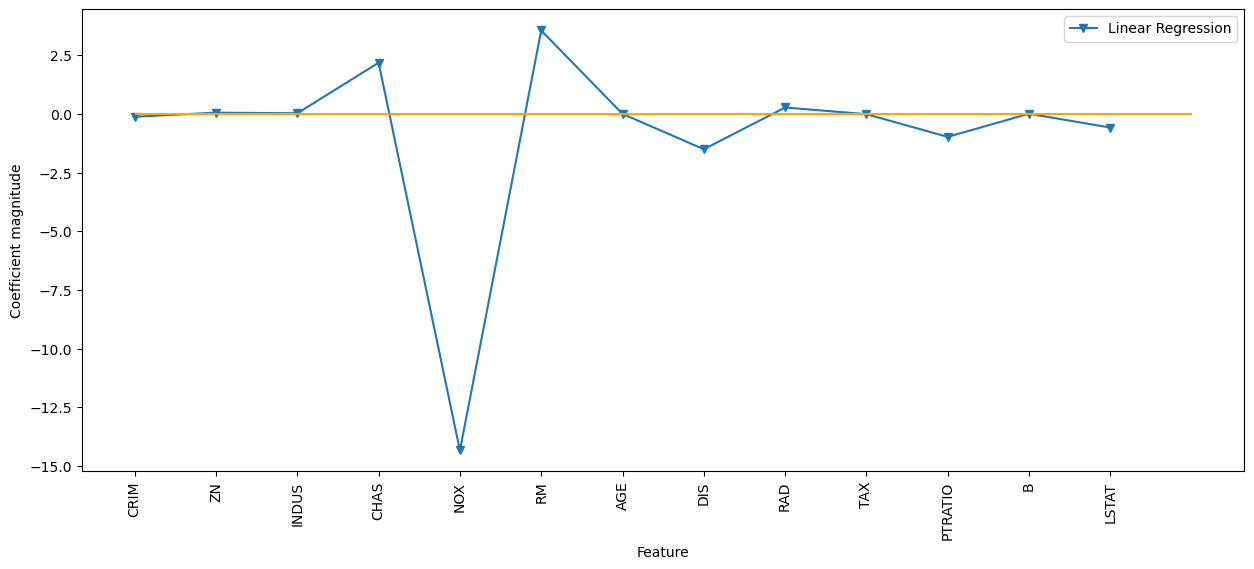

In [10]:
fig = plt.figure(figsize=(15, 6))
plt.plot(lr.coef_.T, '-v', label="Linear Regression")
plt.xticks(range(df_features.shape[1]), df_features.columns, rotation=90)
plt.hlines(0,0, df_features.shape[1],'orange')
plt.xlabel("Feature")
plt.ylabel("Coefficient magnitude")
plt.legend()

print("Weight of the top predictor = %f" %np.amax(np.abs(lr.coef_.T))) #Determine which among the coefficients has the highest value
print("Top Predictor = %s" %df_features.columns[np.argmax(np.abs(lr.coef_.T))])

Let us put this in bargraph normalize with the top predictor.

(-1.0, 13.0)

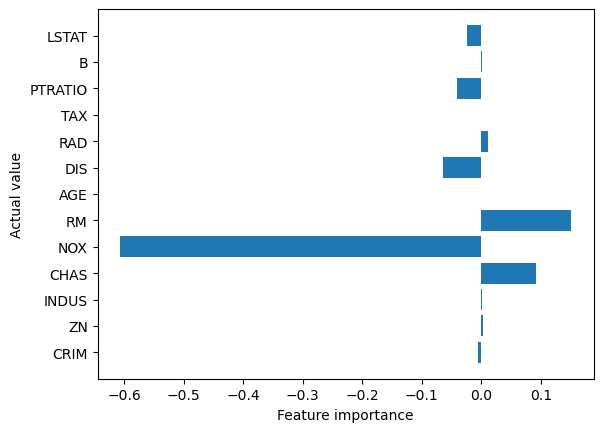

In [11]:
weights_normalized= lr.coef_.T/np.sum(np.abs(lr.coef_.T))

import numpy as np

n_features=13
plt.barh(range(n_features), weights_normalized, align='center')
plt.yticks(np.arange(n_features),df_features.columns)
plt.xlabel("Feature importance")
plt.ylabel("Actual value")
plt.ylim(-1,n_features)

Variables with positive coefficients
- `RM`: average number of rooms per dwelling.
- `CHAS`: Charles River dummy variable (= 1 if tract bounds river; 0 otherwise).
- `ZN`: proportion of residential land zoned for lots over 25,000 sq.ft.
- `INDUS`: proportion of non-retail business acres per town.

Variables with negative coefficients
- `NOX`: nitrogen oxides concentration (parts per 10 million).
- `DIS`: weighted mean of distances to five Boston employment centres.
- `PTRATIO`: pupil-teacher ratio by town.
- `LSTAT`: % of pop with low socioeconomic status.
- `CRIM`: per capita crime rate by town.

### Ridge Regression (L2 Regularization)

Ridge regression is also a linear model for regression, so the formula it uses to make predictions is the same as for ordinary least squares. In Ridge regression,the coefficients w are chosen not only so that they predict well on the training data, but there is an additional constraint. We also want the magnitude of coefficients to be as
small as possible; in other words, all entries of $w$ should be close to $0$.

Intuitively, this means each feature should have as little effect on the outcome as possible (which translates to having a small slope), while still predicting well. This constraint is an example of what is called regularization. Regularization means explicitly restricting a model to avoid overfitting. The particular kind used by Ridge
regression is known as **L2** regularization.

Mathematically, Ridge penalizes the **L2** norm of the coefficients, or the Euclidean length of $w$.  That is the cost or error function is now given by:

\begin{equation}
\mathbf{E}=\frac{(y_{i}-\hat{y})^2}{2} + \alpha \sum_i w[i]^2
\end{equation}


where $\alpha$ is the L2 regularization parameter that can be interpreted as:

--- when $\alpha = 0$  The objective becomes same as simple linear regression.

--- when $\alpha = \infty$  The coefficients will be zero because of infinite weightage on square of coefficients, anything less than zero will make the objective infinite.

---when $0< \alpha <\infty$  The magnitude of $\alpha$ will decide the weightage given to different parts of objective. The coefficients will be somewhere between 0 and ones for simple linear regression. (see: https://www.analyticsvidhya.com/blog/2016/01/complete-tutorial-ridge-lasso-regression-python/)

Ridge regression is implemented in **linear_model.Ridge**. Let’s see how well it does on the extended Boston dataset.


In [12]:
from sklearn.linear_model import Ridge
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size =.25)
ridge = Ridge(alpha=1).fit(X_train, y_train)
print("training set score: %f" % ridge.score(X_train, y_train))
print("test set score: %f" % ridge.score(X_test, y_test))

training set score: 0.757832
test set score: 0.670549


In [13]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import Ridge
training_accuracy = []
test_accuracy = []

for seedN in range(1,100,1):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=seedN)
    ridge = Ridge(alpha=.4).fit(X_train, y_train)

    training_accuracy.append(ridge.score(X_train, y_train)) # record training set accuracy
    test_accuracy.append(ridge.score(X_test, y_test))   # record generalization accuracy

print("TRAIN SET: Mean = ", np.mean(training_accuracy), " Stdev = ", np.std(training_accuracy))
print(" TEST SET: Mean = ", np.mean(test_accuracy)," Stdev = ", np.std(test_accuracy))

TRAIN SET: Mean =  0.7425112890339627  Stdev =  0.013108151905294662
 TEST SET: Mean =  0.7120391497146775  Stdev =  0.04595265366268198


As you can see, the training set score of Ridge is lower than for LinearRegression,
while the test set score is higher. This is consistent with our expectation. With linear regression, we were overfitting our data. Ridge is a more restricted model, so we are less likely to overfit.

*A less complex model means worse performance on the training set, but better generalization. As we are only interested in generalization performance, we should choose the Ridge model over the LinearRegression model.*

The Ridge model makes a trade-off between the simplicity of the model (near zero coefficients) and its performance on the training set. How much importance the model places on simplicity versus training set performance can be specified by the user, using the *alpha* $\alpha$ parameter. Above, we used the default parameter $\alpha$=1.0. There is no reason why this would give us the best trade-off, though.

In general,
1. Increasing alpha forces coefficients to move more towards zero, which decreases training set performance, but might help in improving generalization.

2. Decreasing alpha allows the coefficients to be less restricted. For very small values of alpha, coefficients are barely restricted at all, and we end up with a model that resembles LinearRegression.

In [14]:
param=.001
ridge001 = Ridge(alpha=param).fit(X_train, y_train)
print("for alpha =", param)
print("training set score: %f" % ridge001.score(X_train, y_train))
print("test set score: %f \n " % ridge001.score(X_test, y_test))

param=.1
ridge1 = Ridge(alpha=param).fit(X_train, y_train)
print("for alpha =", param)
print("training set score: %f" % ridge1.score(X_train, y_train))
print("test set score: %f \n " % ridge1.score(X_test, y_test))

param=.4
ridge4 = Ridge(alpha=param).fit(X_train, y_train)
print("for alpha =", param)
print("training set score: %f" % ridge4.score(X_train, y_train))
print("test set score: %f \n " % ridge4.score(X_test, y_test))

param=1
ridge_default = Ridge(alpha=param).fit(X_train, y_train)
print("for alpha =", param)
print("training set score: %f" % ridge_default.score(X_train, y_train))
print("test set score: %f \n" % ridge_default.score(X_test, y_test))

param=10
ridge10 = Ridge(alpha=param).fit(X_train, y_train)
print("for alpha =", param)
print("training set score: %f" % ridge10.score(X_train, y_train))
print("test set score: %f" % ridge10.score(X_test, y_test))

for alpha = 0.001
training set score: 0.756185
test set score: 0.687081 
 
for alpha = 0.1
training set score: 0.756137
test set score: 0.685807 
 
for alpha = 0.4
training set score: 0.755680
test set score: 0.682587 
 
for alpha = 1
training set score: 0.754527
test set score: 0.678173 

for alpha = 10
training set score: 0.749266
test set score: 0.664182


Here, the x-axis enumerates the entries of coef_: x=0 shows the coefficient associated
with the first feature, x=1 the coefficient associated with the second feature, and so on up to x=100. The y-axis shows the numeric value of the corresponding value of the
coefficient. The main take-away here is that for alpha=10 (as shown by the green
dots), the coefficients are mostly between around -3 and 3. The coefficients for the
ridge model with alpha=1 (as shown by the blue dots), are somewhat larger. The red
dots have larger magnitude still, and many of the teal dots, corresponding to linear
regression without any regularization (which would be alpha=0) are so large they are
even outside of the chart.

Weight of the top predictor = 10.695905
Top Predictor is Column 5


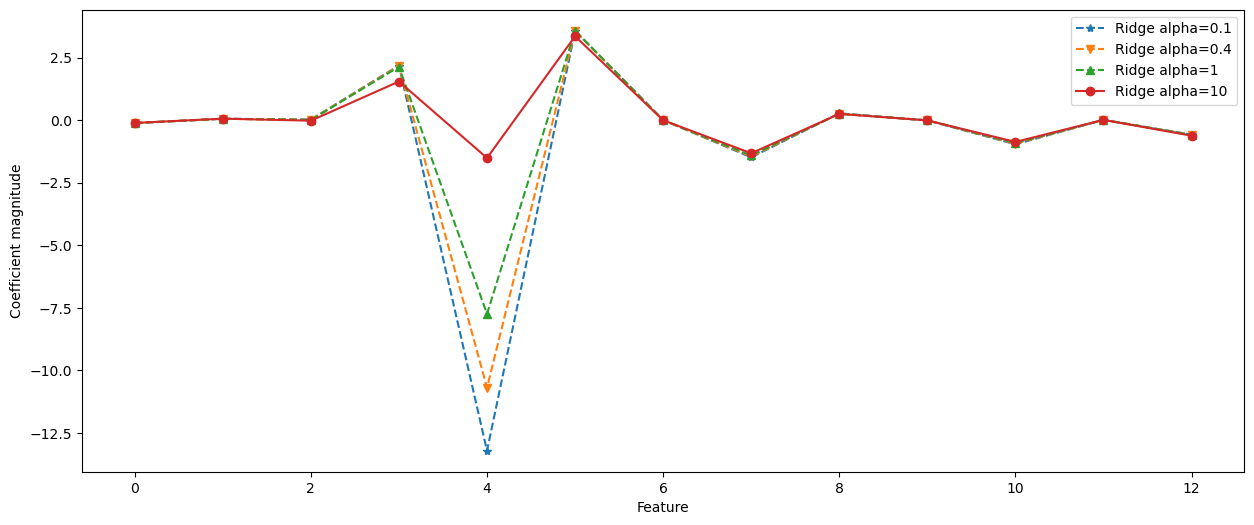

In [15]:
fig = plt.figure(figsize=(15, 6))

plt.plot(ridge1.coef_.T, '--*', label="Ridge alpha=0.1")
plt.plot(ridge4.coef_.T, '--v', label="Ridge alpha=0.4")
plt.plot(ridge_default.coef_.T, '--^', label="Ridge alpha=1")
plt.plot(ridge10.coef_.T, '-o', label="Ridge alpha=10")
#plt.plot(ridge001.coef_.T, '--*', label="Ridge alpha=0.001")
#plt.plot(lr.coef_.T, 'v', label="LinearRegression")
#plt.xticks(range(boston.data.shape[1]), boston.feature_names, rotation=90)
#plt.hlines(0,0, boston.data.shape[1])
#plt.ylim(-20, 20)
plt.xlabel("Feature")
plt.ylabel("Coefficient magnitude")
plt.legend()

print("Weight of the top predictor = %f" %np.amax(np.abs(ridge4.coef_.T)))
print("Top Predictor is Column %s" %np.abs(np.argmax(ridge4.coef_.T)))

(-1.0, 13.0)

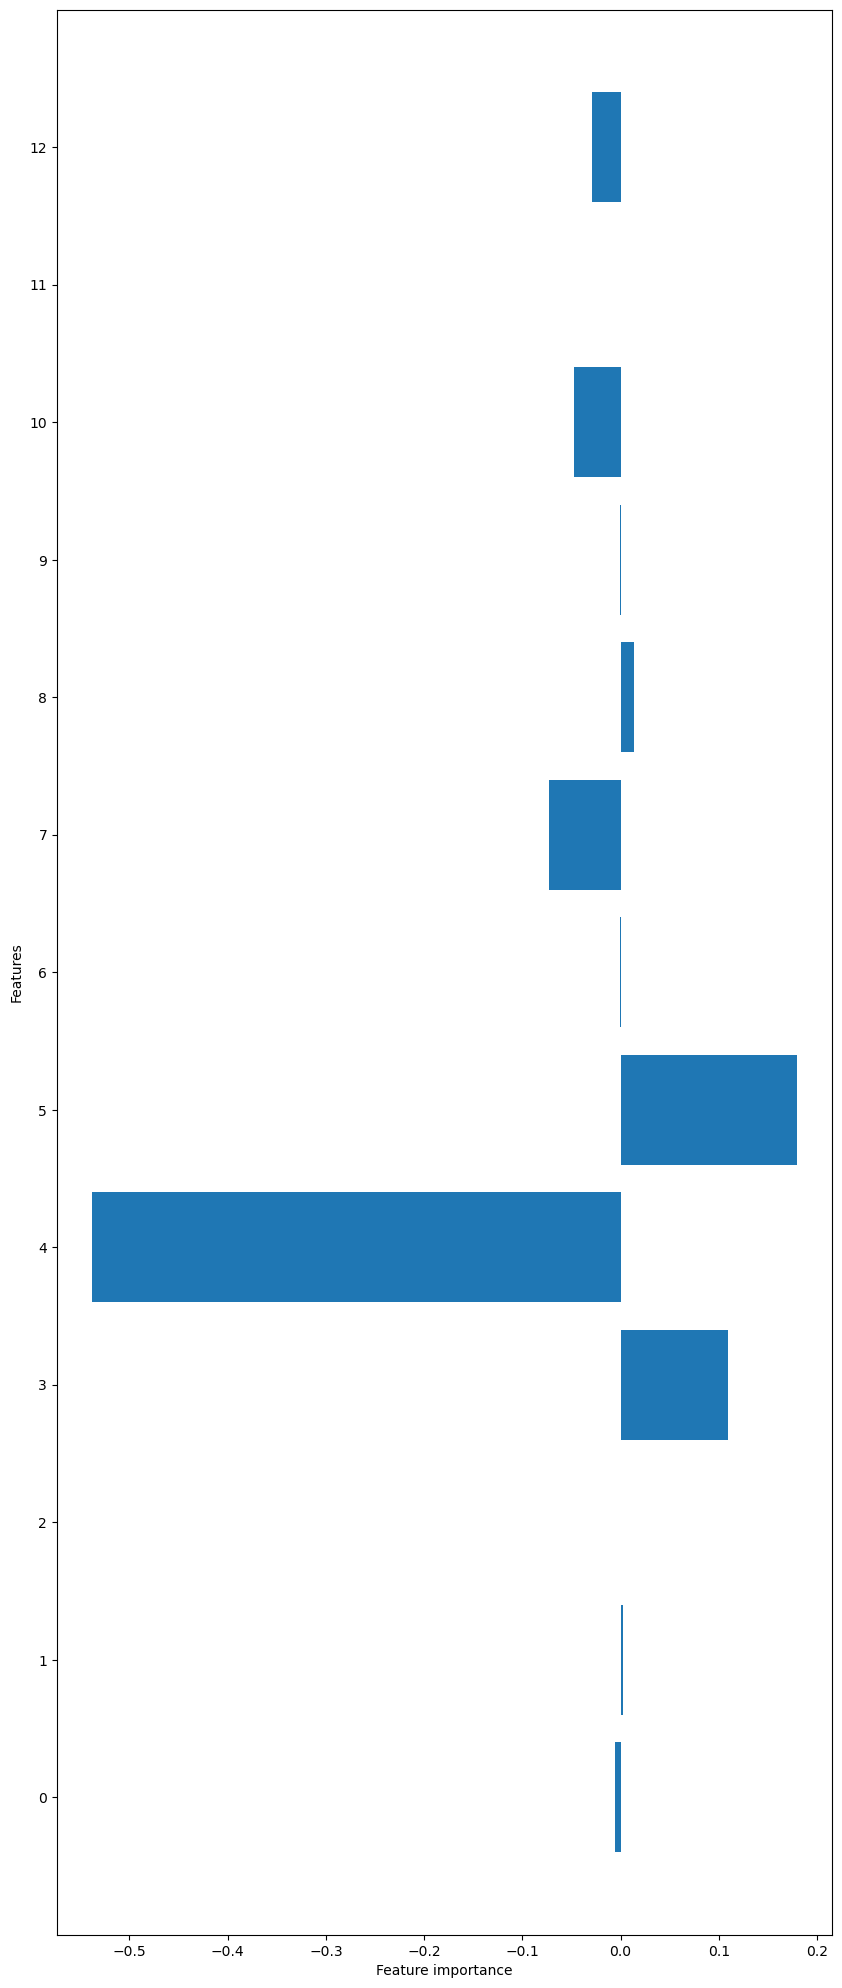

In [16]:
weights_normalized= ridge4.coef_.T/np.sum(np.abs(ridge4.coef_.T))


import numpy as np

fig = plt.figure(figsize=(10, 25))
n_features=13
plt.barh(range(n_features), weights_normalized, align='center')
plt.yticks(np.arange(n_features))
plt.xlabel("Feature importance")
plt.ylabel("Features")
plt.ylim(-1,n_features)

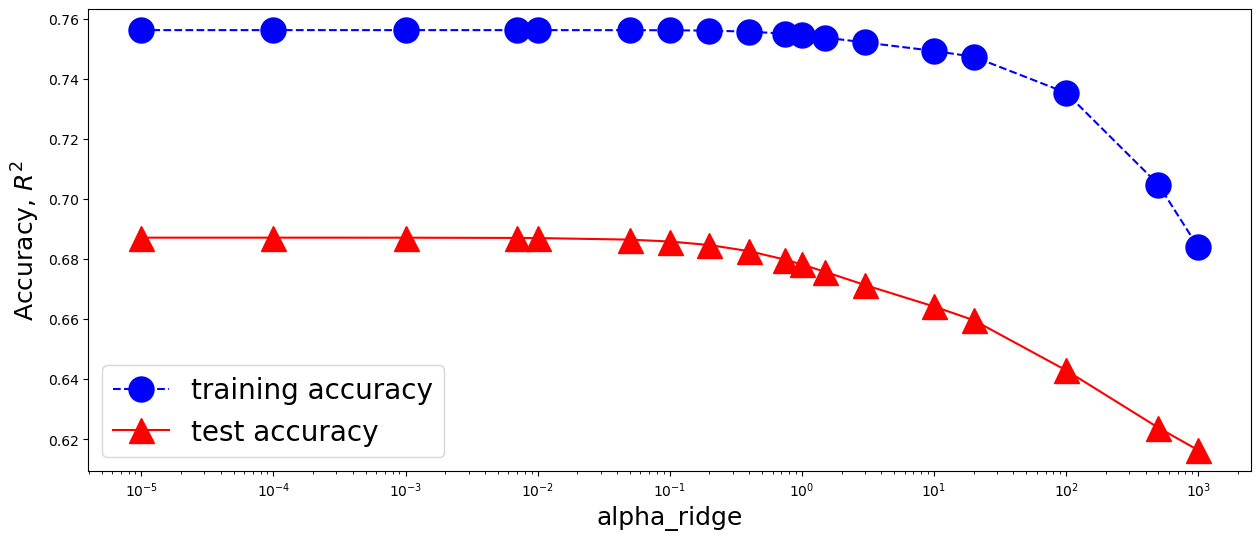

In [17]:
training_accuracy = []
test_accuracy = []
alpha_ridge = [1e-5, 1e-4, 1e-3, 7e-3, 1e-2, 5e-2, 0.1, 0.2,0.4, 0.75, 1, 1.5, 3, 10, 20, 100, 500,1000]

for alpha_run in alpha_ridge:
    ridge = Ridge(alpha=alpha_run).fit(X_train, y_train)
    training_accuracy.append(ridge.score(X_train, y_train))
    test_accuracy.append(ridge.score(X_test, y_test))


fig = plt.figure(figsize=(15, 6))

import pylab as plot
plt.xscale('log')
params = {'legend.fontsize': 20, 'legend.handlelength': 2}
plot.rcParams.update(params)
plt.plot(alpha_ridge, training_accuracy, label="training accuracy", color='blue', marker='o', linestyle='dashed', markersize=18)
plt.plot(alpha_ridge, test_accuracy, label="test accuracy",color='red', marker='^', linestyle='-', markersize=18)
plt.ylabel("Accuracy, $R^2$", fontsize=18)
plt.xlabel("alpha_ridge",fontsize=18)
plt.legend()
pass

Running the Ridge over multiple trials

In [18]:
No_Trials=20 # Number of Trials

#X, y = mglearn.datasets.load_extended_boston()

all_training = pd.DataFrame()
all_test = pd.DataFrame()


for seedN in range(1,No_Trials,1):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=seedN)
    training_accuracy = []
    test_accuracy = []
    alpha_parameter = [1e-5, 1e-4, 1e-3, 7e-3, 1e-2, 5e-2, 0.1, 0.2,0.4, 0.75, 1, 1.5, 3, 10, 20, 100, 500, 1000,10000, 100000] #Tuning Parameters

    for alpha_run in alpha_parameter:
        reg = Ridge(alpha=alpha_run) # Define here wether Lasso or Ridge
        reg.fit(X_train, y_train) #build the model
        training_accuracy.append(reg.score(X_train, y_train)) # record training set accuracy
        test_accuracy.append(reg.score(X_test, y_test)) # record generalization accuracy
    all_training[seedN]=training_accuracy
    all_test[seedN] = test_accuracy

Best Accuracy = 0.709549
With lpha given by 0.000010


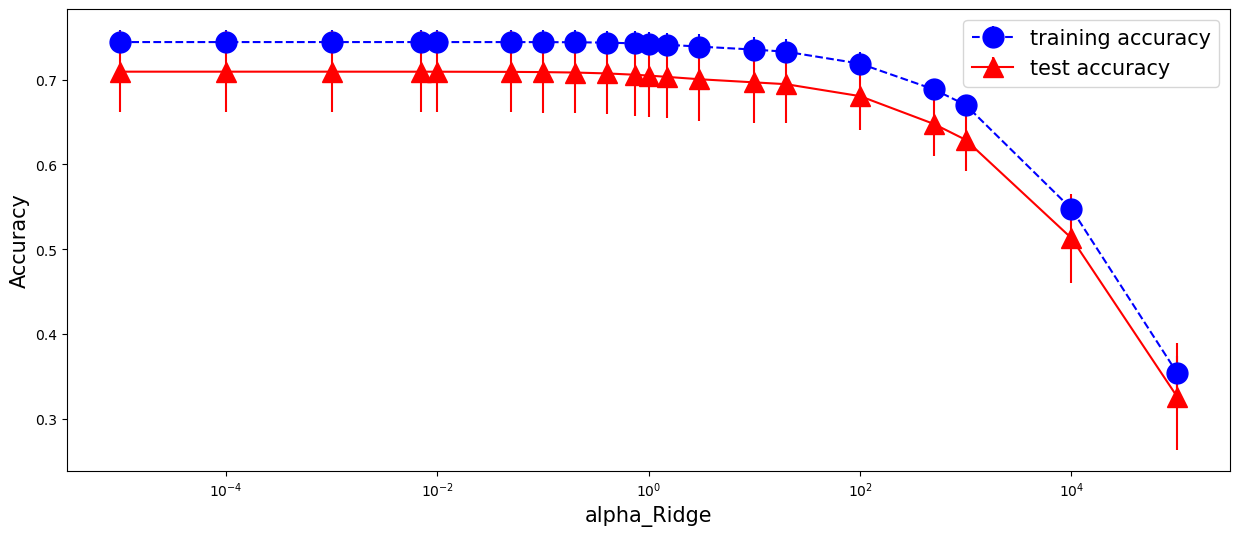

In [19]:
fig = plt.figure(figsize=(15, 6))
import pylab as plot
plt.xscale('log')
#plt.yscale('log')
params = {'legend.fontsize': 15, 'legend.handlelength': 2}
plot.rcParams.update(params)

plt.errorbar(alpha_parameter, all_training.mean(axis=1),
             yerr=all_training.std(axis=1), label="training accuracy", color='blue', marker='o', linestyle='dashed', markersize=15)
plt.errorbar(alpha_parameter, all_test.mean(axis=1),
             yerr=all_test.std(axis=1), label="test accuracy", color='red', marker='^', linestyle='-', markersize=15)
plt.ylabel("Accuracy", fontsize=15)
plt.xlabel("alpha_Ridge",fontsize=15)
plt.legend()

print("Best Accuracy = %f" %np.max(all_test.mean(axis=1)))
print("With \alpha given by %f" %alpha_parameter[np.argmax(all_test.mean(axis=1))])

### Lasso Regression (L1 Regularization)

An alternative to Ridge for regularizing linear regression is the Lasso. The lasso also restricts coefficients to be close to zero, similarly to Ridge regression, but in a slightly different way, called **L1 regularization**.

The Lasso penalizes the L1 norm of the coefficient vector, or in other words the sum of the absolute values of the coefficients, mathematically the cost or error function is now given by:

\begin{equation}
\mathbf{E}=\frac{(y_{i}-\hat{y})^2}{2} + \alpha \sum_i \lvert w[i] \rvert
\end{equation}

\begin{equation}
\mathbf{E}=\frac{(y_{i}-\hat{y})^2}{2} + \alpha_1 \sum_i \lvert w[i] \rvert + \alpha_2 \sum_i w[i]^2
\end{equation}

The consequence of L1 regularization is that when using the Lasso, some coefficients
are exactly zero. This means some features are entirely ignored by the model. This can
be seen as a form of automatic feature selection. Having some coefficients be exactly
zero often makes a model easier to interpret, and can reveal the most important features of your model.

In [20]:
from sklearn.linear_model import Lasso
lasso_default = Lasso().fit(X_train, y_train)
print("training set score: %f" % lasso_default.score(X_train, y_train))
print("test set score: %f" % lasso_default.score(X_test, y_test))
print("number of features used: %d" % np.sum(lasso_default.coef_ != 0))

training set score: 0.685802
test set score: 0.586308
number of features used: 10


As you can see, the Lasso does quite badly, both on the training and the test set. This indicates that we are underfitting. We find that it only used 10 of the 13 features. Similarly to Ridge, the Lasso also has a regularization parameter alpha that controls how strongly coefficients are pushed towards zero. Above, we used the default of alpha=1.0. To diminish underfitting, let’s try decreasing alpha.

*Geeky optional note: The algorithm to make the system converge depends on iterations implemented (**max_iter**) and for low value of $\alpha$ we need to increase it manually to assure convergence.*

In [21]:
#We must increase "max_iter" if not the model would warn us to increase it

lasso2 = Lasso(alpha=5, max_iter=10000).fit(X_train, y_train)
print("training set score: %f" % lasso2.score(X_train, y_train))
print("test set score: %f" % lasso2.score(X_test, y_test))
print("number of features used: %d" % np.sum(lasso2.coef_ != 0))

training set score: 0.573087
test set score: 0.454056
number of features used: 5


In [22]:
lasso007 = Lasso(alpha=0.007, max_iter=10000).fit(X_train, y_train)
print("training set score: %f" % lasso007.score(X_train, y_train))
print("test set score: %f" % lasso007.score(X_test, y_test))
print("number of features used: %d" % np.sum(lasso007.coef_ != 0))

training set score: 0.751089
test set score: 0.687627
number of features used: 13


In [23]:
lasso01 = Lasso(alpha=0.01, max_iter=10000).fit(X_train, y_train)
print("training set score: %f" % lasso01.score(X_train, y_train))
print("test set score: %f" % lasso01.score(X_test, y_test))
print("number of features used: %d" % np.sum(lasso01.coef_ != 0))

training set score: 0.750840
test set score: 0.686841
number of features used: 13


In [24]:
lasso001 = Lasso(alpha=0.001, max_iter=100000).fit(X_train, y_train)
print("training set score: %f" % lasso001.score(X_train, y_train))
print("test set score: %f" % lasso001.score(X_test, y_test))
print("number of features used: %d" % np.sum(lasso001.coef_ != 0))

training set score: 0.751323
test set score: 0.689013
number of features used: 13


A lower alpha allowed us to fit a more complex model, which worked better on the
training and the test data. The performance is slightly better than using Ridge, and we
are using only 13 of the 13 features. This makes this model potentially easier to
understand.
If we set alpha too low, we again remove the effect of regularization and end up with a
result similar to LinearRegression.

In [25]:
lasso00001 = Lasso(alpha=0.0001, max_iter=100000).fit(X_train, y_train)
print("training set score: %f" % lasso00001.score(X_train, y_train))
print("test set score: %f" % lasso00001.score(X_test, y_test))
print("number of features used: %d" % np.sum(lasso00001.coef_ != 0))

training set score: 0.751328
test set score: 0.689199
number of features used: 13


Again, we can plot the coefficients of the different models, similarly to Figure
ridge_coefficients.

For alpha=1, with coefficients shown as blue dots, we not only see that most of the
coefficients are zero (which we already knew), but that the remaining coefficients are
also small in magnitude. Decreasing alpha to 0.01 we obtain the solution shown as
the green dots, which causes most features be exactly zero. Using alpha=0.00001, we
get a model that is quite unregularized, with most coefficients nonzero and of large
magnitude.
For comparison, the best Ridge solution is shown in teal. The ridge model with
alpha=0.1 has similar predictive performance as the lasso model with alpha=0.01, but
using Ridge, all coefficients are non-zero.

Weight of the top predictor = 3.392499
Top Predictor is Column 5
number of features used: 13


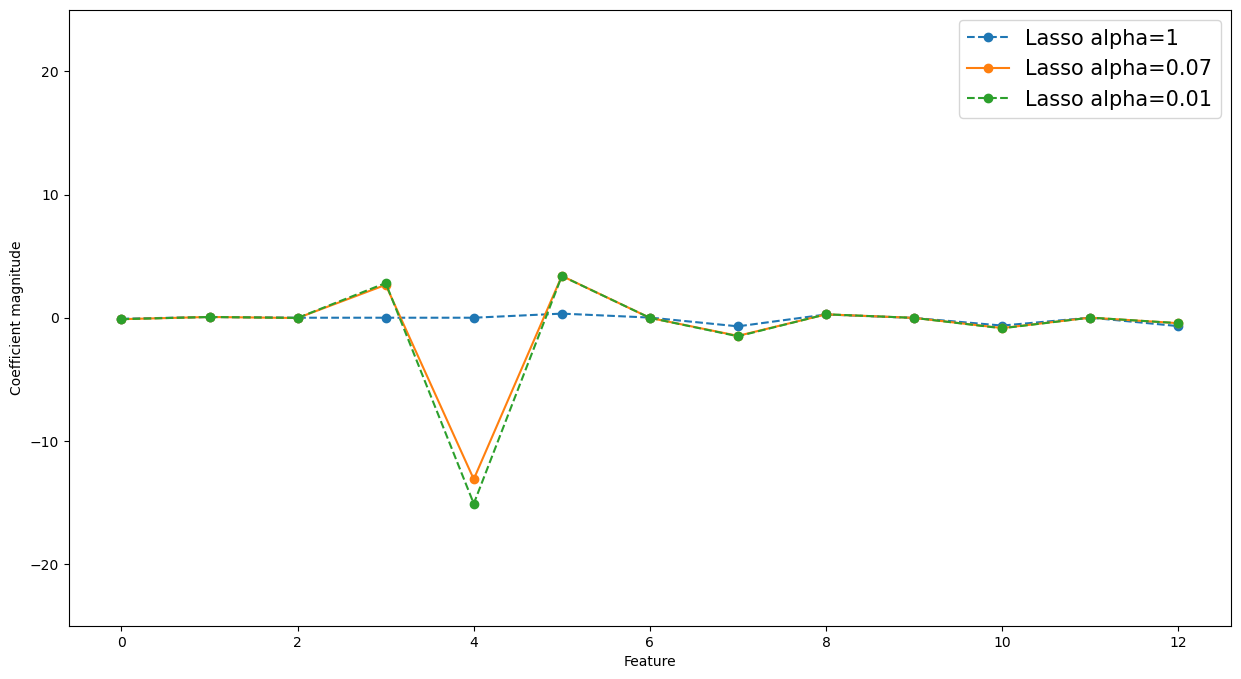

In [26]:
fig = plt.figure(figsize=(15, 8))

plt.plot(lasso_default.coef_, 'o--', label="Lasso alpha=1")
plt.plot(lasso007.coef_, 'o-', label="Lasso alpha=0.07")
plt.plot(lasso001.coef_, 'o--', label="Lasso alpha=0.01")
#plt.plot(ridge1.coef_, 'o-', label="Ridge alpha=0.1")
plt.ylim(-25, 25)

#plt.ylim(-20, 20)
plt.xlabel("Feature")
plt.ylabel("Coefficient magnitude")
plt.legend()


print("Weight of the top predictor = %f" %np.abs(np.amax(lasso007.coef_.T)))
print("Top Predictor is Column %s" %np.abs(np.argmax(lasso007.coef_.T)))
#print("Top Predictor = %s" %boston.feature_names[np.argmax(  )
print("number of features used: %d" % np.sum(lasso007.coef_ != 0))


(-1.0, 13.0)

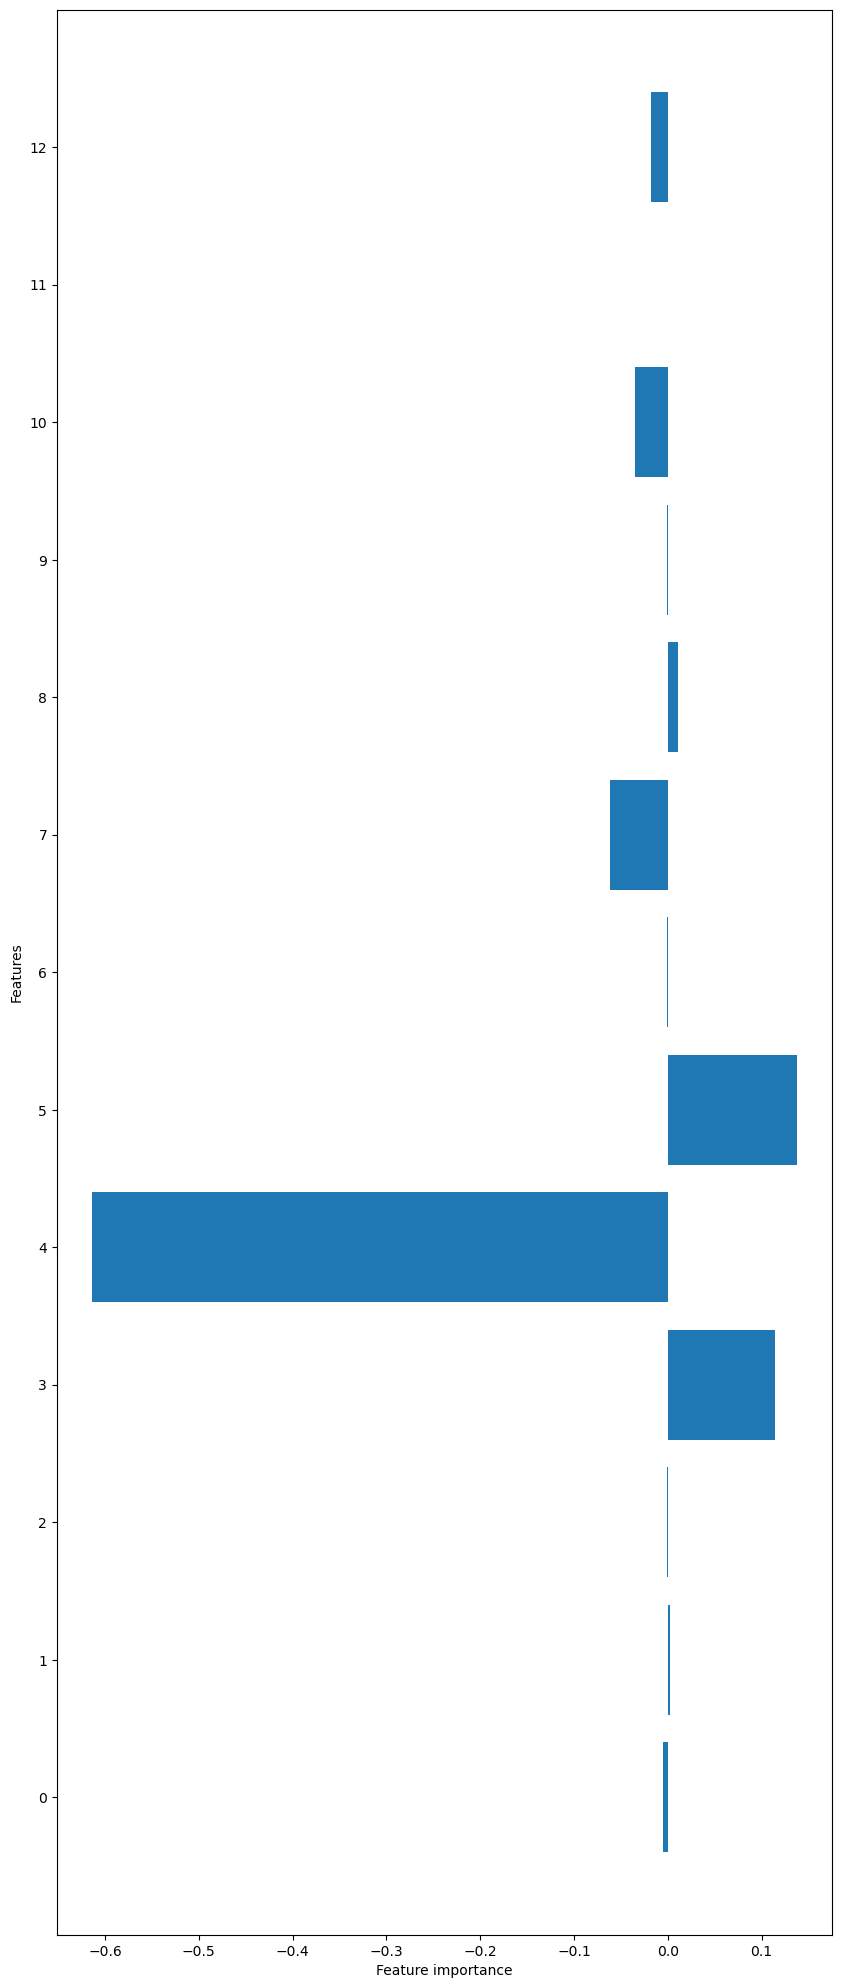

In [27]:
weights_normalized= lasso001.coef_.T/np.sum(np.abs(lasso001.coef_.T))

import numpy as np

fig = plt.figure(figsize=(10, 25))
n_features=13
plt.barh(range(n_features), weights_normalized, align='center')
plt.yticks(np.arange(n_features))
plt.xlabel("Feature importance")
plt.ylabel("Features")
plt.ylim(-1,n_features)

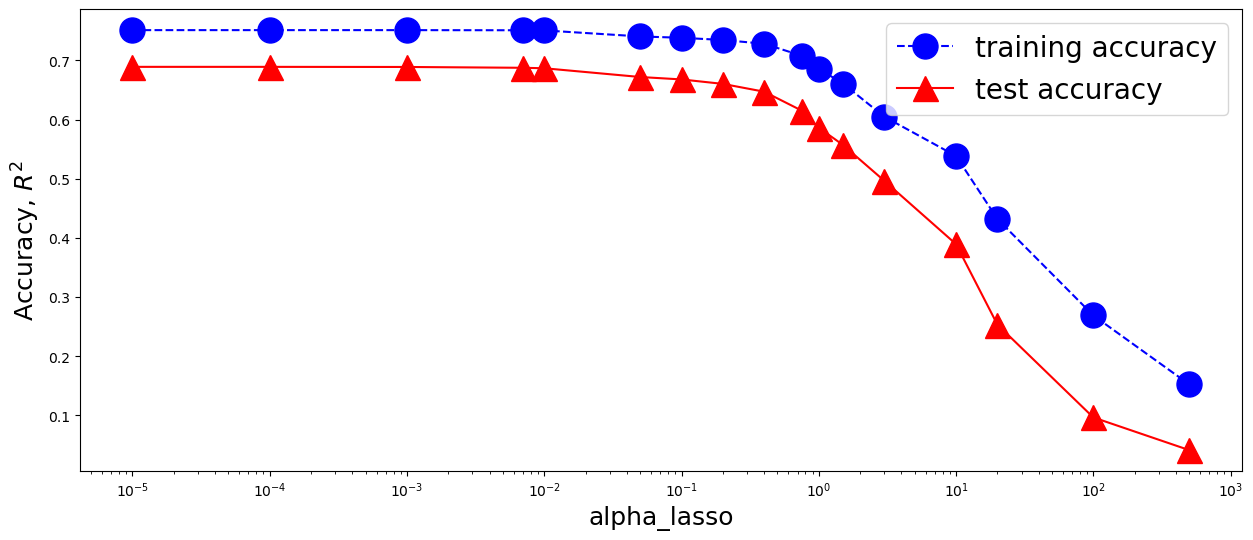

In [28]:
training_accuracy = []
test_accuracy = []
alpha_lasso = [1e-5, 1e-4, 1e-3, 7e-3, 1e-2, 5e-2, 0.1, 0.2,0.4, 0.75, 1, 1.5, 3, 10, 20, 100, 500]

for alpha_run in alpha_lasso:
    lasso = Lasso(alpha=alpha_run,max_iter=100000).fit(X_train, y_train)
    training_accuracy.append(lasso.score(X_train, y_train))
    test_accuracy.append(lasso.score(X_test, y_test))
    #print("alpha_run: %f" % alpha_run)
    #print("training set score: %f" % ridge.score(X_train, y_train))
    #print("test set score: %f\n" % ridge.score(X_test, y_test))

fig = plt.figure(figsize=(15, 6))

import pylab as plot
plt.xscale('log')
params = {'legend.fontsize': 20, 'legend.handlelength': 2}
plot.rcParams.update(params)
plt.plot(alpha_lasso, training_accuracy, label="training accuracy", color='blue', marker='o', linestyle='dashed', markersize=18)
plt.plot(alpha_lasso, test_accuracy, label="test accuracy",color='red', marker='^', linestyle='-', markersize=18)
plt.ylabel("Accuracy, $R^2$", fontsize=18)
plt.xlabel("alpha_lasso",fontsize=18)
plt.legend()
pass

Running the Lasso over multiple trials

In [29]:
No_Trials=10 # Number of Trials

#X, y = mglearn.datasets.load_extended_boston()

all_training = pd.DataFrame()
all_test = pd.DataFrame()


for seedN in range(1,No_Trials,1):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=seedN)
    training_accuracy = []
    test_accuracy = []
    alpha_parameter = [1e-5, 1e-4, 1e-3, 7e-3, 1e-2, 5e-2, 0.1, 0.2,0.4, 0.75, 1, 1.5, 3, 10, 20, 100, 500] #Tuning Parameters

    for alpha_run in alpha_parameter:
        reg = Lasso(alpha=alpha_run, max_iter=100000) # Define here wether Lasso or Ridge
        reg.fit(X_train, y_train) #build the model
        training_accuracy.append(reg.score(X_train, y_train)) # record training set accuracy
        test_accuracy.append(reg.score(X_test, y_test)) # record generalization accuracy
    all_training[seedN]=training_accuracy
    all_test[seedN] = test_accuracy

print("Best Accuracy = %f" %np.max(all_test.mean(axis=1)))
print("With \alpha given by %f" %alpha_parameter[np.argmax(all_test.mean(axis=1))])

Best Accuracy = 0.726627
With lpha given by 0.000010


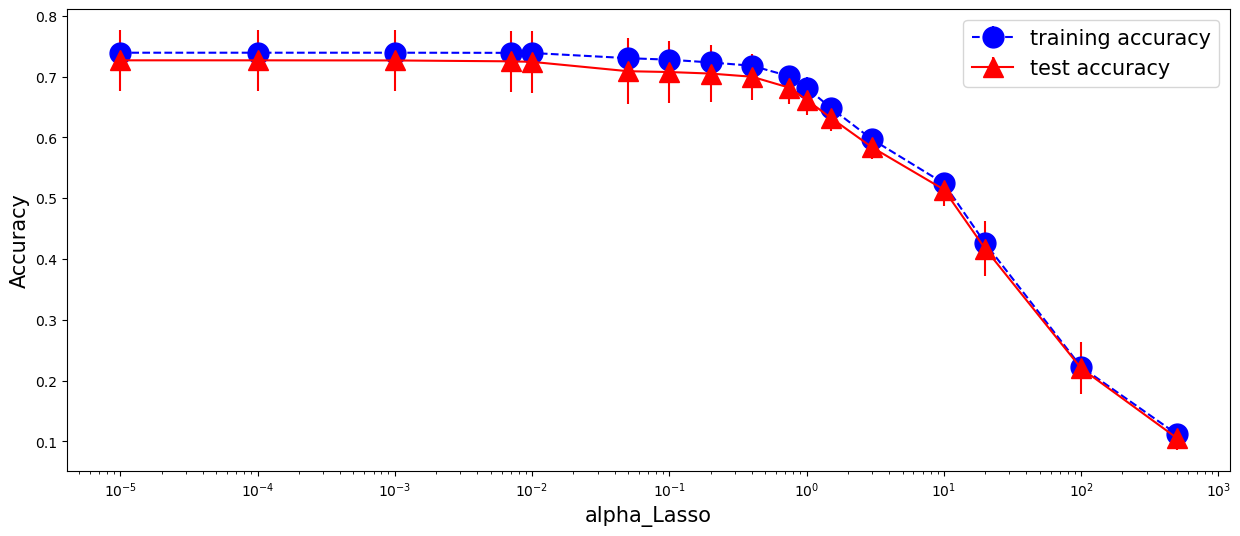

In [30]:
fig = plt.figure(figsize=(15, 6))
import pylab as plot
plt.xscale('log')
#plt.yscale('log')
params = {'legend.fontsize': 15, 'legend.handlelength': 2}
plot.rcParams.update(params)

plt.errorbar(alpha_parameter, all_training.mean(axis=1),
             yerr=all_training.std(axis=1), label="training accuracy", color='blue', marker='o', linestyle='dashed', markersize=15)
plt.errorbar(alpha_parameter, all_test.mean(axis=1),
             yerr=all_test.std(axis=1), label="test accuracy", color='red', marker='^', linestyle='-', markersize=15)
plt.ylabel("Accuracy", fontsize=15)
plt.xlabel("alpha_Lasso",fontsize=15)
plt.legend()

## Task 2: Ridge & Lasso (Parkinson's Dataset)

### Without Feature Engineering

#### Simple Linear Regression

In [31]:
data = pd.read_excel('parkinsons_updrs.xlsx')
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5875 entries, 0 to 5874
Data columns (total 22 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   subject#       5875 non-null   int64  
 1   age            5875 non-null   int64  
 2   sex            5875 non-null   int64  
 3   test_time      5875 non-null   float64
 4   motor_score    5875 non-null   float64
 5   Jitter(%)      5875 non-null   float64
 6   Jitter(Abs)    5875 non-null   float64
 7   Jitter:RAP     5875 non-null   float64
 8   Jitter:PPQ5    5875 non-null   float64
 9   Jitter:DDP     5875 non-null   float64
 10  Shimmer        5875 non-null   float64
 11  Shimmer(dB)    5875 non-null   float64
 12  Shimmer:APQ3   5875 non-null   float64
 13  Shimmer:APQ5   5875 non-null   float64
 14  Shimmer:APQ11  5875 non-null   float64
 15  Shimmer:DDA    5875 non-null   float64
 16  NHR            5875 non-null   float64
 17  HNR            5875 non-null   float64
 18  RPDE    

In [32]:
data.head()

,subject#,age,sex,test_time,motor_score,Jitter(%),Jitter(Abs),Jitter:RAP,Jitter:PPQ5,Jitter:DDP,...,Shimmer:APQ3,Shimmer:APQ5,Shimmer:APQ11,Shimmer:DDA,NHR,HNR,RPDE,DFA,PPE,Target
0,1,72,0,5.6,28,0.0066,3.4e-05,0.004,0.0032,0.012,...,0.014,0.013,0.017,0.043,0.014,22,0.42,0.55,0.16,34
1,1,72,0,13,28,0.003,1.7e-05,0.0013,0.0015,0.004,...,0.0099,0.011,0.017,0.03,0.011,27,0.43,0.56,0.11,35
2,1,72,0,20,29,0.0048,2.5e-05,0.0021,0.0021,0.0062,...,0.0073,0.0084,0.015,0.022,0.02,23,0.46,0.54,0.21,35
3,1,72,0,26,29,0.0053,2.7e-05,0.0019,0.0026,0.0057,...,0.011,0.013,0.02,0.033,0.028,24,0.49,0.58,0.33,36
4,1,72,0,34,29,0.0034,2e-05,0.00093,0.0013,0.0028,...,0.0068,0.0093,0.018,0.02,0.012,26,0.47,0.56,0.19,36


In [33]:
data_features=data.drop('Target', axis=1) #Remove the target column X
data_target=data['Target']
len(data_features)
data_features.head(5)

,subject#,age,sex,test_time,motor_score,Jitter(%),Jitter(Abs),Jitter:RAP,Jitter:PPQ5,Jitter:DDP,...,Shimmer(dB),Shimmer:APQ3,Shimmer:APQ5,Shimmer:APQ11,Shimmer:DDA,NHR,HNR,RPDE,DFA,PPE
0,1,72,0,5.6,28,0.0066,3.4e-05,0.004,0.0032,0.012,...,0.23,0.014,0.013,0.017,0.043,0.014,22,0.42,0.55,0.16
1,1,72,0,13,28,0.003,1.7e-05,0.0013,0.0015,0.004,...,0.18,0.0099,0.011,0.017,0.03,0.011,27,0.43,0.56,0.11
2,1,72,0,20,29,0.0048,2.5e-05,0.0021,0.0021,0.0062,...,0.18,0.0073,0.0084,0.015,0.022,0.02,23,0.46,0.54,0.21
3,1,72,0,26,29,0.0053,2.7e-05,0.0019,0.0026,0.0057,...,0.33,0.011,0.013,0.02,0.033,0.028,24,0.49,0.58,0.33
4,1,72,0,34,29,0.0034,2e-05,0.00093,0.0013,0.0028,...,0.18,0.0068,0.0093,0.018,0.02,0.012,26,0.47,0.56,0.19


In [34]:
X, y = data_features, data_target # Load data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size =.25, random_state=8) # Define training/test set
lr = LinearRegression().fit(X_train, y_train) #Fit the training data for the chosen ML model

In [35]:
print("Training set score R^2: %f" % lr.score(X_train, y_train))
print("Test set score R^2: %f" % lr.score(X_test, y_test))

Training set score R^2: 0.910973
Test set score R^2: 0.906364


Average over 100 trials

In [36]:
training_accuracy = []
test_accuracy = []

for seedN in range(1,100,1):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=seedN)
    lr = LinearRegression().fit(X_train, y_train)

    training_accuracy.append(lr.score(X_train, y_train)) # record training set accuracy
    test_accuracy.append(lr.score(X_test, y_test))   # record generalization accuracy

print("TRAIN SET: Mean = ", np.mean(training_accuracy), " Stdev = ", np.std(training_accuracy))
print(" TEST SET: Mean = ", np.mean(test_accuracy)," Stdev = ", np.std(test_accuracy))

TRAIN SET: Mean =  0.9101045782105971  Stdev =  0.0011707791803451304
 TEST SET: Mean =  0.9089324614040404  Stdev =  0.003598316943670553


Weight of the top predictor = 15901.438302
Top Predictor = Jitter(Abs)


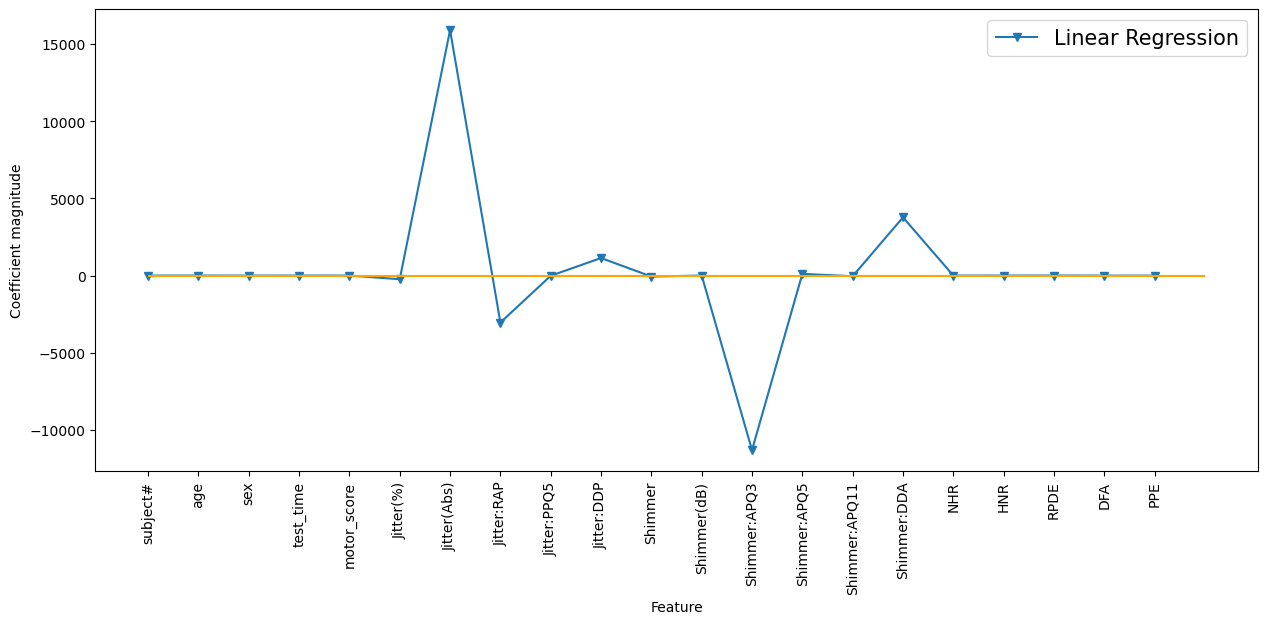

In [37]:
fig = plt.figure(figsize=(15, 6))
plt.plot(lr.coef_.T, '-v', label="Linear Regression")
plt.xticks(range(data_features.shape[1]), data_features.columns, rotation=90)
plt.hlines(0,0, data_features.shape[1],'orange')
plt.xlabel("Feature")
plt.ylabel("Coefficient magnitude")
plt.legend()

print("Weight of the top predictor = %f" %np.amax(np.abs(lr.coef_.T))) #Determine which among the coefficients has the highest value
print("Top Predictor = %s" %data_features.columns[np.argmax(np.abs(lr.coef_.T))])

(-1.0, 21.0)

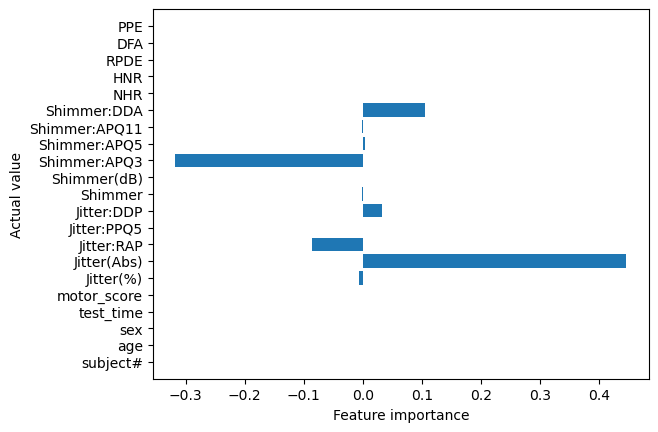

In [38]:
weights_normalized= lr.coef_.T/np.sum(np.abs(lr.coef_.T))

import numpy as np

n_features=21
plt.barh(range(n_features), weights_normalized, align='center')
plt.yticks(np.arange(n_features),data_features.columns)
plt.xlabel("Feature importance")
plt.ylabel("Actual value")
plt.ylim(-1,n_features)

#### Ridge Regression (L2 Regularization)

In [39]:
from sklearn.linear_model import Ridge
# from sklearn.preprocessing import MinMaxScaler
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size =.25)
# scaler = MinMaxScaler(feature_range=(0, 1))
# scaler.fit(X_train) # X_train is your training data
# X_train = scaler.transform(X_train)
# X_test = scaler.transform(X_test) # Apply the *same* scaler to test data
ridge = Ridge(alpha=1).fit(X_train, y_train)
print("training set score: %f" % ridge.score(X_train, y_train))
print("test set score: %f" % ridge.score(X_test, y_test))

training set score: 0.906946
test set score: 0.912149


In [40]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import Ridge
training_accuracy = []
test_accuracy = []

for seedN in range(1,100,1):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=seedN)
    ridge = Ridge(alpha=.4).fit(X_train, y_train)

    training_accuracy.append(ridge.score(X_train, y_train)) # record training set accuracy
    test_accuracy.append(ridge.score(X_test, y_test))   # record generalization accuracy

print("TRAIN SET: Mean = ", np.mean(training_accuracy), " Stdev = ", np.std(training_accuracy))
print(" TEST SET: Mean = ", np.mean(test_accuracy)," Stdev = ", np.std(test_accuracy))

TRAIN SET: Mean =  0.9085972283084828  Stdev =  0.0011751260658663923
 TEST SET: Mean =  0.9081002767582379  Stdev =  0.003567286106537336


In [41]:
param=.001
ridge001 = Ridge(alpha=param).fit(X_train, y_train)
print("for alpha =", param)
print("training set score: %f" % ridge001.score(X_train, y_train))
print("test set score: %f \n " % ridge001.score(X_test, y_test))

param=.1
ridge1 = Ridge(alpha=param).fit(X_train, y_train)
print("for alpha =", param)
print("training set score: %f" % ridge1.score(X_train, y_train))
print("test set score: %f \n " % ridge1.score(X_test, y_test))

param=.4
ridge4 = Ridge(alpha=param).fit(X_train, y_train)
print("for alpha =", param)
print("training set score: %f" % ridge4.score(X_train, y_train))
print("test set score: %f \n " % ridge4.score(X_test, y_test))

param=1
ridge_default = Ridge(alpha=param).fit(X_train, y_train)
print("for alpha =", param)
print("training set score: %f" % ridge_default.score(X_train, y_train))
print("test set score: %f \n" % ridge_default.score(X_test, y_test))

param=10
ridge10 = Ridge(alpha=param).fit(X_train, y_train)
print("for alpha =", param)
print("training set score: %f" % ridge10.score(X_train, y_train))
print("test set score: %f" % ridge10.score(X_test, y_test))

for alpha = 0.001
training set score: 0.909475
test set score: 0.909136 
 
for alpha = 0.1
training set score: 0.908847
test set score: 0.908604 
 
for alpha = 0.4
training set score: 0.908551
test set score: 0.908400 
 
for alpha = 1
training set score: 0.908323
test set score: 0.908238 

for alpha = 10
training set score: 0.907828
test set score: 0.908082


Weight of the top predictor = 12.161921
Top Predictor is Column 15


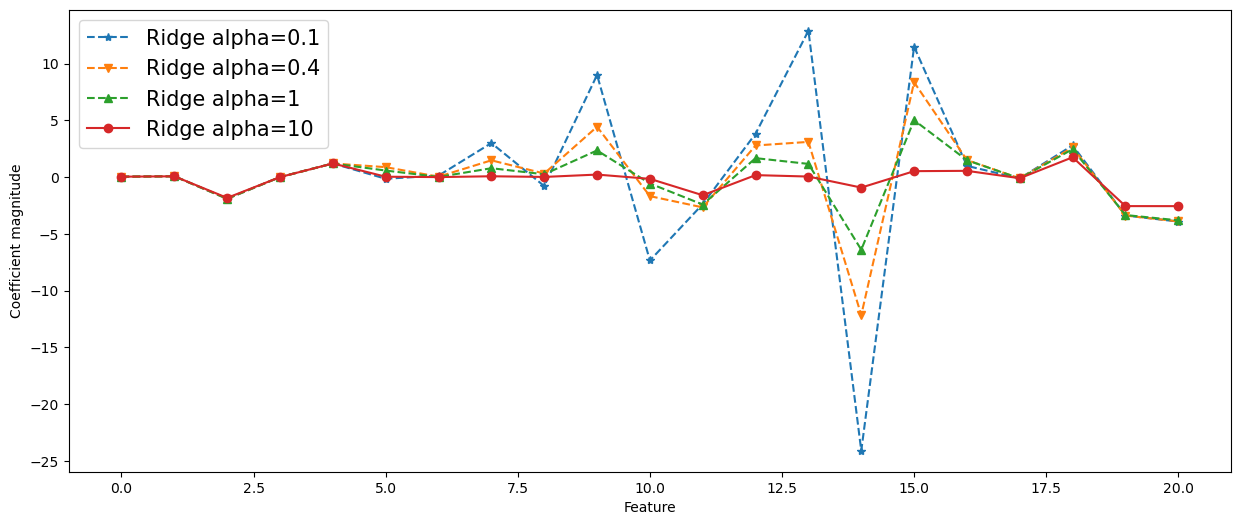

In [42]:
fig = plt.figure(figsize=(15, 6))

plt.plot(ridge1.coef_.T, '--*', label="Ridge alpha=0.1")
plt.plot(ridge4.coef_.T, '--v', label="Ridge alpha=0.4")
plt.plot(ridge_default.coef_.T, '--^', label="Ridge alpha=1")
plt.plot(ridge10.coef_.T, '-o', label="Ridge alpha=10")
#plt.plot(ridge001.coef_.T, '--*', label="Ridge alpha=0.001")
#plt.plot(lr.coef_.T, 'v', label="LinearRegression")
#plt.xticks(range(boston.data.shape[1]), boston.feature_names, rotation=90)
#plt.hlines(0,0, boston.data.shape[1])
#plt.ylim(-20, 20)
plt.xlabel("Feature")
plt.ylabel("Coefficient magnitude")
plt.legend()

print("Weight of the top predictor = %f" %np.amax(np.abs(ridge4.coef_.T)))
print("Top Predictor is Column %s" %np.abs(np.argmax(ridge4.coef_.T)))

(-1.0, 21.0)

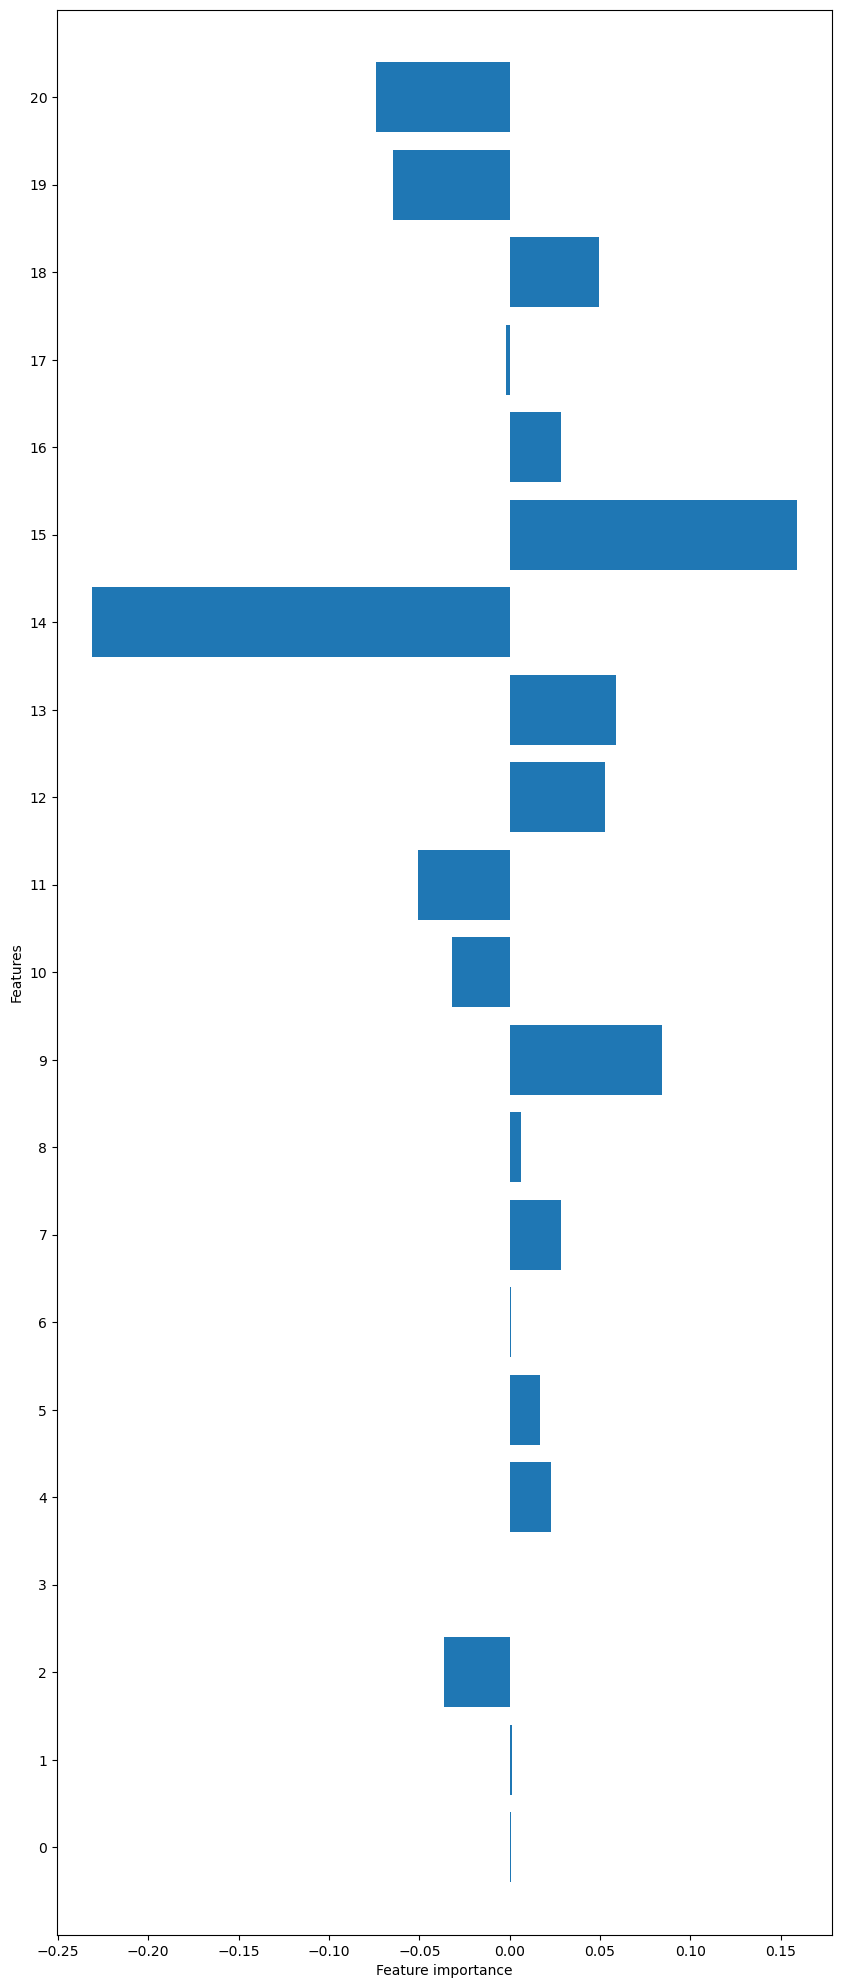

In [43]:
weights_normalized = ridge4.coef_.T/np.sum(np.abs(ridge4.coef_.T))


import numpy as np

fig = plt.figure(figsize=(10, 25))
n_features=21
plt.barh(range(n_features), weights_normalized, align='center')
plt.yticks(np.arange(n_features))
plt.xlabel("Feature importance")
plt.ylabel("Features")
plt.ylim(-1,n_features)

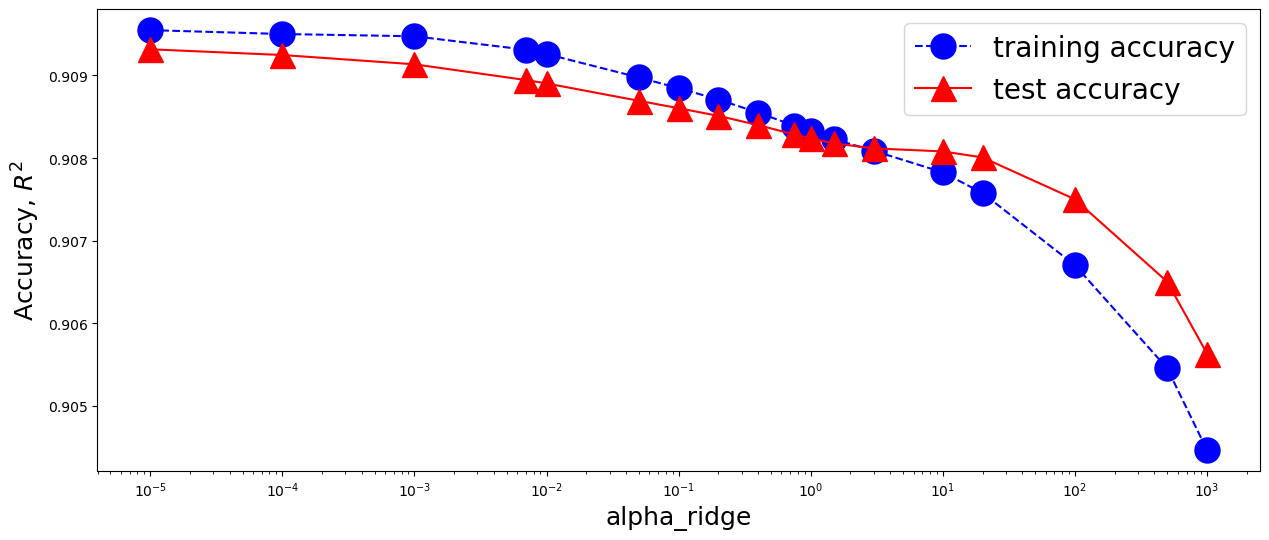

In [44]:
training_accuracy = []
test_accuracy = []
alpha_ridge = [1e-5, 1e-4, 1e-3, 7e-3, 1e-2, 5e-2, 0.1, 0.2,0.4, 0.75, 1, 1.5, 3, 10, 20, 100, 500,1000]

for alpha_run in alpha_ridge:
    ridge = Ridge(alpha=alpha_run).fit(X_train, y_train)
    training_accuracy.append(ridge.score(X_train, y_train))
    test_accuracy.append(ridge.score(X_test, y_test))


fig = plt.figure(figsize=(15, 6))

import pylab as plot
plt.xscale('log')
params = {'legend.fontsize': 20, 'legend.handlelength': 2}
plot.rcParams.update(params)
plt.plot(alpha_ridge, training_accuracy, label="training accuracy", color='blue', marker='o', linestyle='dashed', markersize=18)
plt.plot(alpha_ridge, test_accuracy, label="test accuracy",color='red', marker='^', linestyle='-', markersize=18)
plt.ylabel("Accuracy, $R^2$", fontsize=18)
plt.xlabel("alpha_ridge",fontsize=18)
plt.legend()
pass

In [45]:
No_Trials=20 # Number of Trials

#X, y = mglearn.datasets.load_extended_boston()

all_training = pd.DataFrame()
all_test = pd.DataFrame()


for seedN in range(1,No_Trials,1):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=seedN)
    training_accuracy = []
    test_accuracy = []
    alpha_parameter = [1e-5, 1e-4, 1e-3, 7e-3, 1e-2, 5e-2, 0.1, 0.2,0.4, 0.75, 1, 1.5, 3, 10, 20, 100, 500, 1000,10000, 100000] #Tuning Parameters

    for alpha_run in alpha_parameter:
        reg = Ridge(alpha=alpha_run) # Define here wether Lasso or Ridge
        reg.fit(X_train, y_train) #build the model
        training_accuracy.append(reg.score(X_train, y_train)) # record training set accuracy
        test_accuracy.append(reg.score(X_test, y_test)) # record generalization accuracy
    all_training[seedN]=training_accuracy
    all_test[seedN] = test_accuracy

Best Accuracy = 0.910025
With lpha given by 0.000010


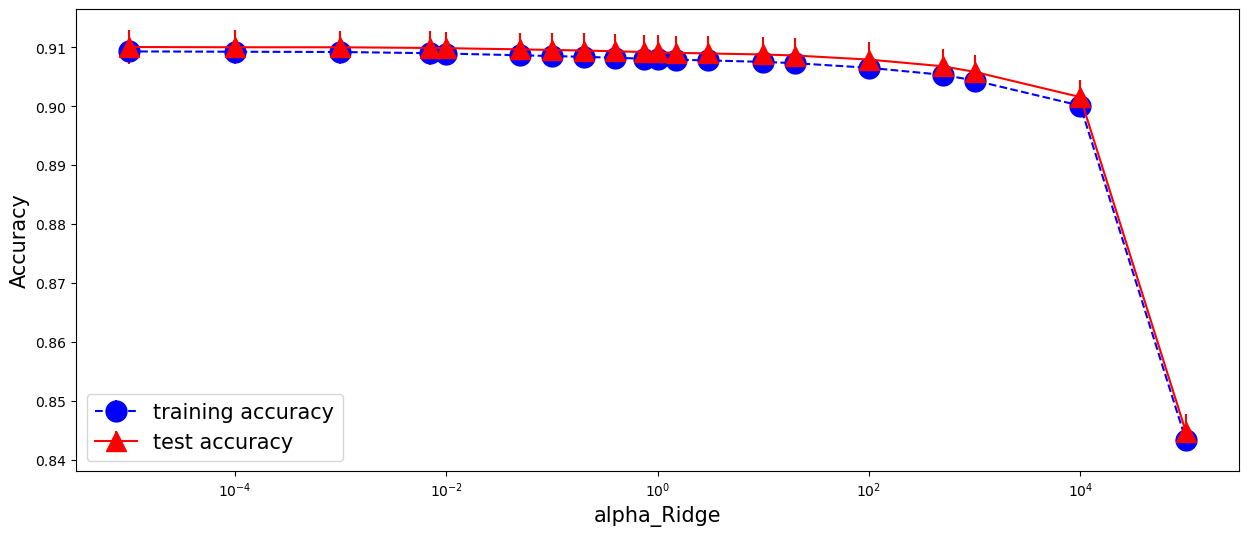

In [46]:
fig = plt.figure(figsize=(15, 6))
import pylab as plot
plt.xscale('log')
#plt.yscale('log')
params = {'legend.fontsize': 15, 'legend.handlelength': 2}
plot.rcParams.update(params)

plt.errorbar(alpha_parameter, all_training.mean(axis=1),
             yerr=all_training.std(axis=1), label="training accuracy", color='blue', marker='o', linestyle='dashed', markersize=15)
plt.errorbar(alpha_parameter, all_test.mean(axis=1),
             yerr=all_test.std(axis=1), label="test accuracy", color='red', marker='^', linestyle='-', markersize=15)
plt.ylabel("Accuracy", fontsize=15)
plt.xlabel("alpha_Ridge",fontsize=15)
plt.legend()

print("Best Accuracy = %f" %np.max(all_test.mean(axis=1)))
print("With \alpha given by %f" %alpha_parameter[np.argmax(all_test.mean(axis=1))])

#### Lasso Regression (L1 Regularization)

In [47]:
from sklearn.linear_model import Lasso
lasso_default = Lasso().fit(X_train, y_train)
print("training set score: %f" % lasso_default.score(X_train, y_train))
print("test set score: %f" % lasso_default.score(X_test, y_test))
print("number of features used: %d" % np.sum(lasso_default.coef_ != 0))

training set score: 0.901021
test set score: 0.898226
number of features used: 4


In [48]:
#We must increase "max_iter" if not the model would warn us to increase it

lasso2 = Lasso(alpha=5, max_iter=10000).fit(X_train, y_train)
print("training set score: %f" % lasso2.score(X_train, y_train))
print("test set score: %f" % lasso2.score(X_test, y_test))
print("number of features used: %d" % np.sum(lasso2.coef_ != 0))

training set score: 0.896087
test set score: 0.894581
number of features used: 3


In [49]:
lasso007 = Lasso(alpha=0.007, max_iter=10000).fit(X_train, y_train)
print("training set score: %f" % lasso007.score(X_train, y_train))
print("test set score: %f" % lasso007.score(X_test, y_test))
print("number of features used: %d" % np.sum(lasso007.coef_ != 0))

training set score: 0.908715
test set score: 0.903703
number of features used: 10


In [50]:
lasso01 = Lasso(alpha=0.01, max_iter=10000).fit(X_train, y_train)
print("training set score: %f" % lasso01.score(X_train, y_train))
print("test set score: %f" % lasso01.score(X_test, y_test))
print("number of features used: %d" % np.sum(lasso01.coef_ != 0))

training set score: 0.908419
test set score: 0.903397
number of features used: 10


In [51]:
lasso001 = Lasso(alpha=0.001, max_iter=100000).fit(X_train, y_train)
print("training set score: %f" % lasso001.score(X_train, y_train))
print("test set score: %f" % lasso001.score(X_test, y_test))
print("number of features used: %d" % np.sum(lasso001.coef_ != 0))

training set score: 0.909537
test set score: 0.904360
number of features used: 13


In [52]:
lasso00001 = Lasso(alpha=0.0001, max_iter=100000).fit(X_train, y_train)
print("training set score: %f" % lasso00001.score(X_train, y_train))
print("test set score: %f" % lasso00001.score(X_test, y_test))
print("number of features used: %d" % np.sum(lasso00001.coef_ != 0))

training set score: 0.910273
test set score: 0.904831
number of features used: 16


Weight of the top predictor = 1.637652
Top Predictor is Column 18
number of features used: 10


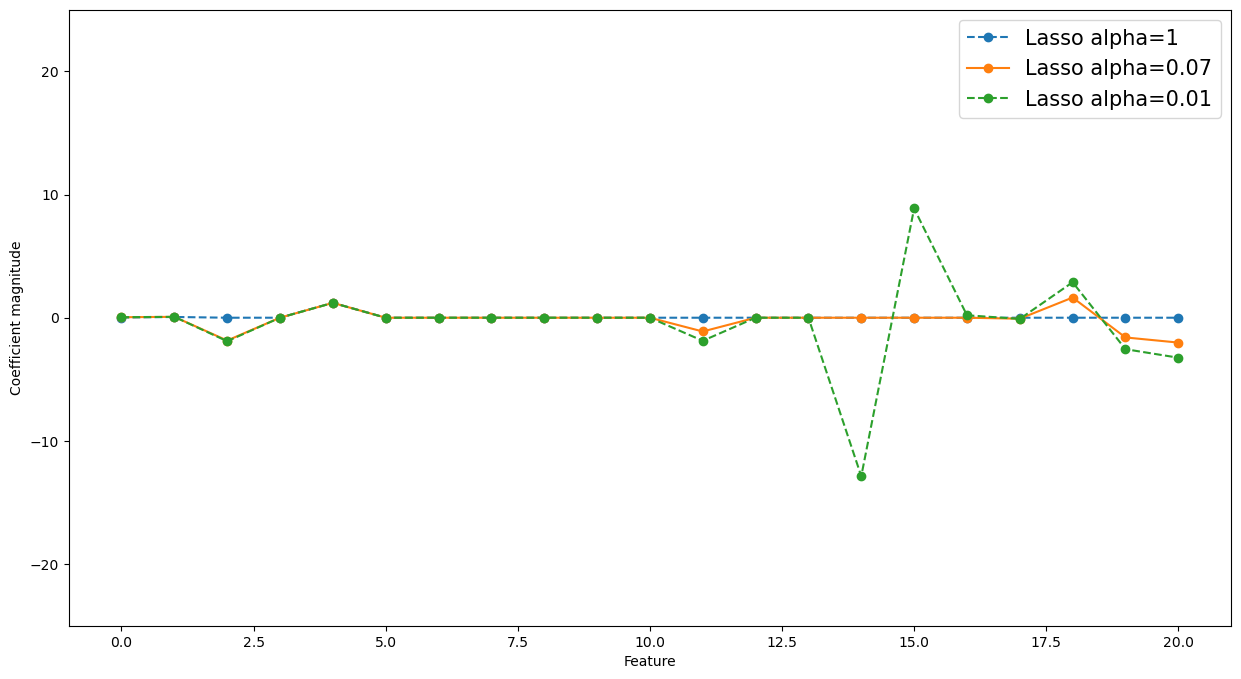

In [53]:
fig = plt.figure(figsize=(15, 8))

plt.plot(lasso_default.coef_, 'o--', label="Lasso alpha=1")
plt.plot(lasso007.coef_, 'o-', label="Lasso alpha=0.07")
plt.plot(lasso001.coef_, 'o--', label="Lasso alpha=0.01")
#plt.plot(ridge1.coef_, 'o-', label="Ridge alpha=0.1")
plt.ylim(-25, 25)

#plt.ylim(-20, 20)
plt.xlabel("Feature")
plt.ylabel("Coefficient magnitude")
plt.legend()


print("Weight of the top predictor = %f" %np.abs(np.amax(lasso007.coef_.T)))
print("Top Predictor is Column %s" %np.abs(np.argmax(lasso007.coef_.T)))
#print("Top Predictor = %s" %boston.feature_names[np.argmax(  )
print("number of features used: %d" % np.sum(lasso007.coef_ != 0))

(-1.0, 21.0)

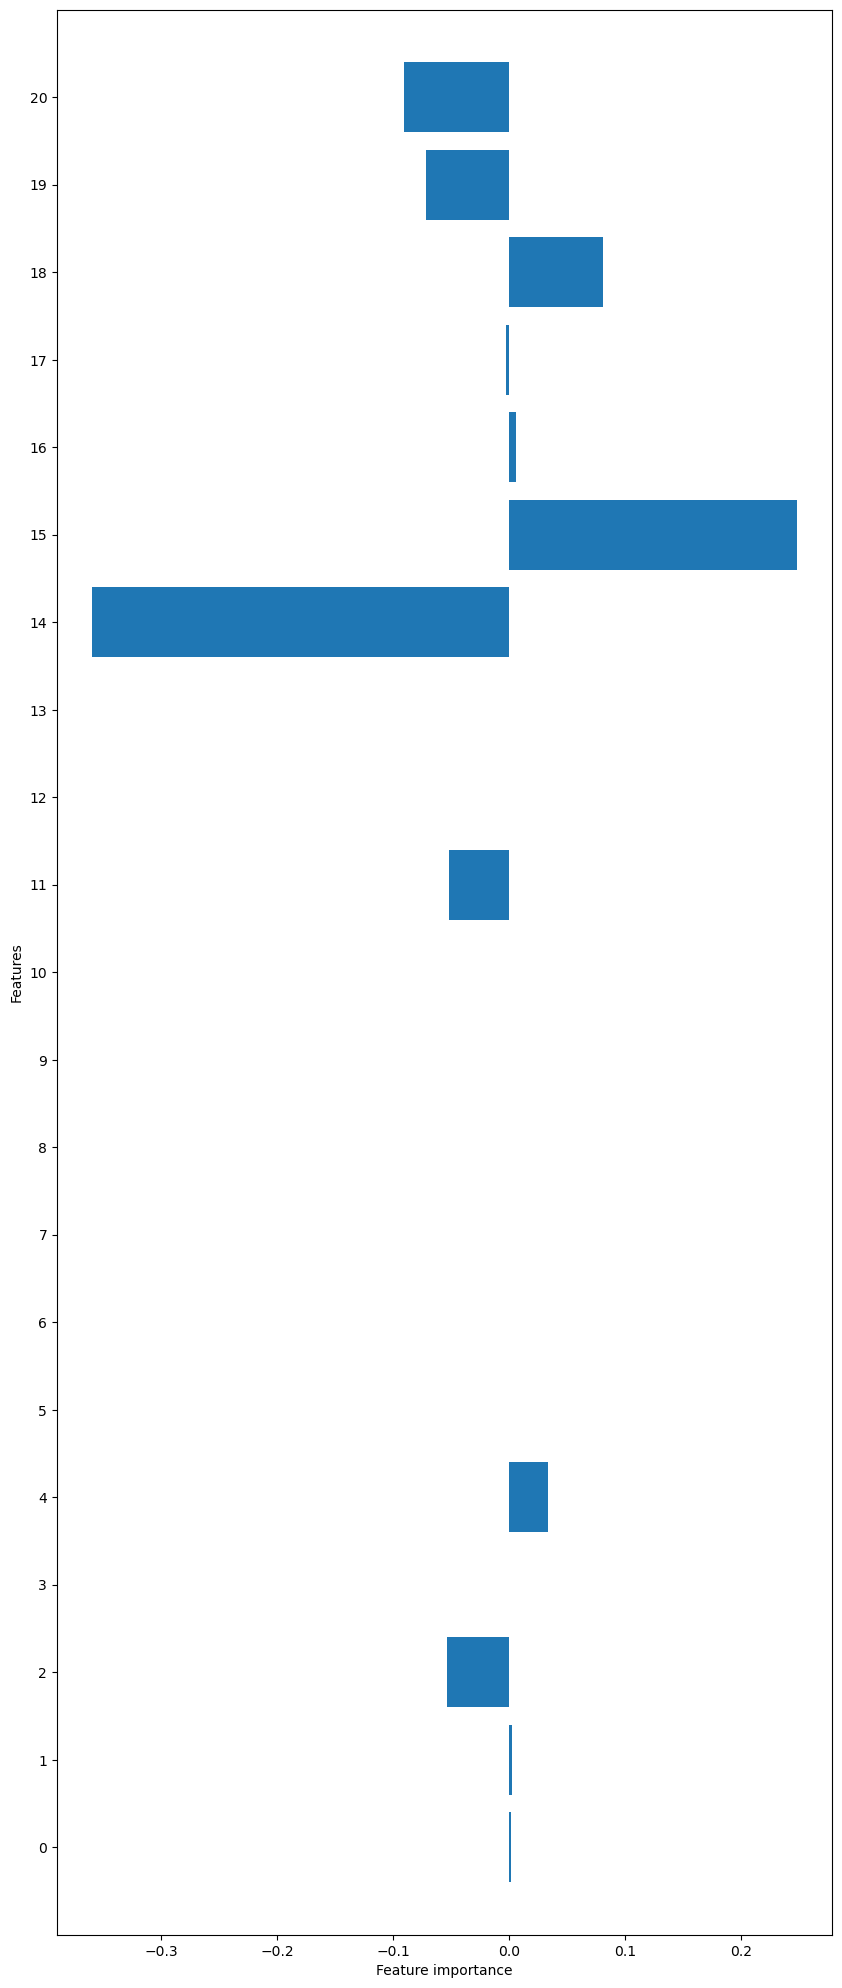

In [54]:
weights_normalized= lasso001.coef_.T/np.sum(np.abs(lasso001.coef_.T))

import numpy as np

fig = plt.figure(figsize=(10, 25))
n_features=21
plt.barh(range(n_features), weights_normalized, align='center')
plt.yticks(np.arange(n_features))
plt.xlabel("Feature importance")
plt.ylabel("Features")
plt.ylim(-1,n_features)

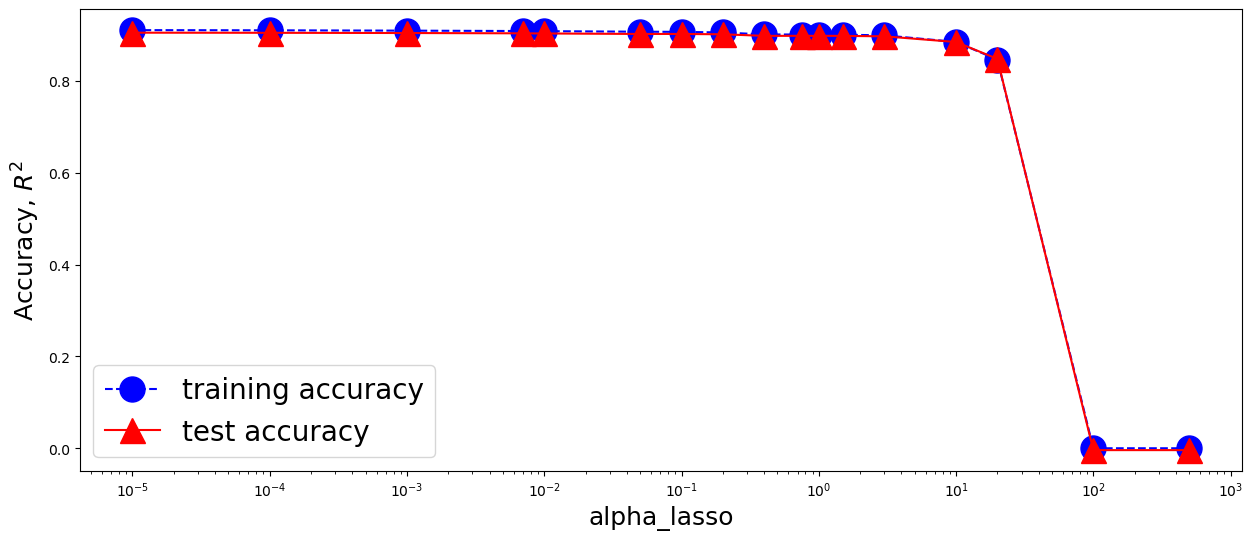

In [55]:
training_accuracy = []
test_accuracy = []
alpha_lasso = [1e-5, 1e-4, 1e-3, 7e-3, 1e-2, 5e-2, 0.1, 0.2,0.4, 0.75, 1, 1.5, 3, 10, 20, 100, 500]

for alpha_run in alpha_lasso:
    lasso = Lasso(alpha=alpha_run,max_iter=100000).fit(X_train, y_train)
    training_accuracy.append(lasso.score(X_train, y_train))
    test_accuracy.append(lasso.score(X_test, y_test))
    #print("alpha_run: %f" % alpha_run)
    #print("training set score: %f" % ridge.score(X_train, y_train))
    #print("test set score: %f\n" % ridge.score(X_test, y_test))

fig = plt.figure(figsize=(15, 6))

import pylab as plot
plt.xscale('log')
params = {'legend.fontsize': 20, 'legend.handlelength': 2}
plot.rcParams.update(params)
plt.plot(alpha_lasso, training_accuracy, label="training accuracy", color='blue', marker='o', linestyle='dashed', markersize=18)
plt.plot(alpha_lasso, test_accuracy, label="test accuracy",color='red', marker='^', linestyle='-', markersize=18)
plt.ylabel("Accuracy, $R^2$", fontsize=18)
plt.xlabel("alpha_lasso",fontsize=18)
plt.legend()
pass

In [56]:
No_Trials=10 # Number of Trials

#X, y = mglearn.datasets.load_extended_boston()

all_training = pd.DataFrame()
all_test = pd.DataFrame()


for seedN in range(1,No_Trials,1):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=seedN)
    training_accuracy = []
    test_accuracy = []
    alpha_parameter = [1e-5, 1e-4, 1e-3, 7e-3, 1e-2, 5e-2, 0.1, 0.2,0.4, 0.75, 1, 1.5, 3, 10, 20, 100, 500] #Tuning Parameters

    for alpha_run in alpha_parameter:
        reg = Lasso(alpha=alpha_run, max_iter=100000) # Define here wether Lasso or Ridge
        reg.fit(X_train, y_train) #build the model
        training_accuracy.append(reg.score(X_train, y_train)) # record training set accuracy
        test_accuracy.append(reg.score(X_test, y_test)) # record generalization accuracy
    all_training[seedN]=training_accuracy
    all_test[seedN] = test_accuracy

print("Best Accuracy = %f" %np.max(all_test.mean(axis=1)))
print("With \alpha given by %f" %alpha_parameter[np.argmax(all_test.mean(axis=1))])

Best Accuracy = 0.910325
With lpha given by 0.000010


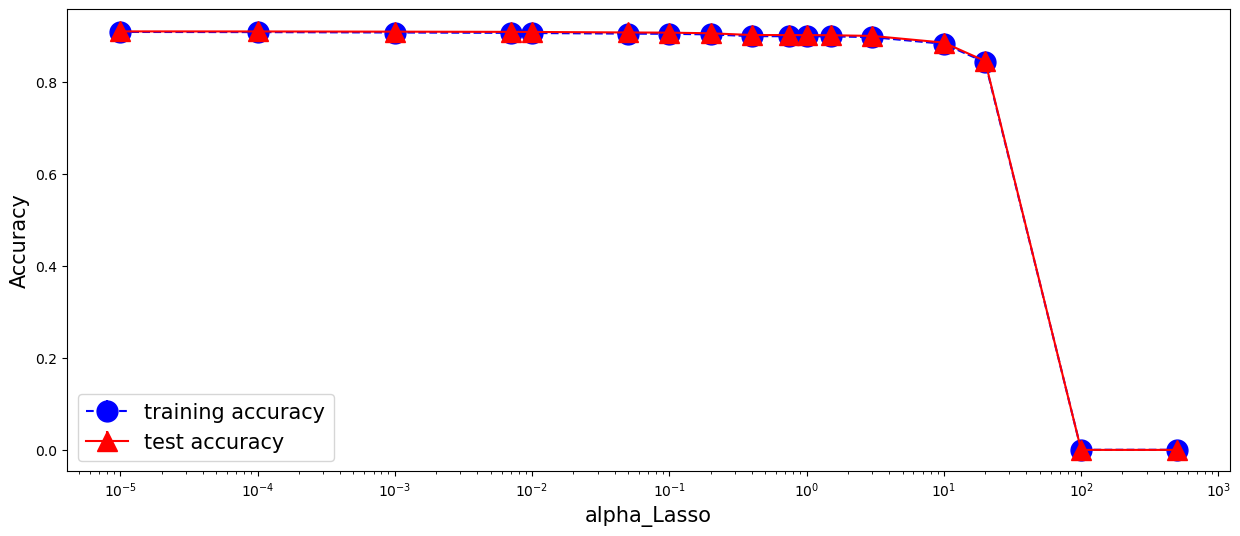

In [57]:
fig = plt.figure(figsize=(15, 6))
import pylab as plot
plt.xscale('log')
#plt.yscale('log')
params = {'legend.fontsize': 15, 'legend.handlelength': 2}
plot.rcParams.update(params)

plt.errorbar(alpha_parameter, all_training.mean(axis=1),
             yerr=all_training.std(axis=1), label="training accuracy", color='blue', marker='o', linestyle='dashed', markersize=15)
plt.errorbar(alpha_parameter, all_test.mean(axis=1),
             yerr=all_test.std(axis=1), label="test accuracy", color='red', marker='^', linestyle='-', markersize=15)
plt.ylabel("Accuracy", fontsize=15)
plt.xlabel("alpha_Lasso",fontsize=15)
plt.legend()

### With Feature Engineering

#### Simple Linear Regression

In [58]:
# Create new columns by multiplying each column with every other column

for i in range(len(data_features.columns)):
    for j in range(i, len(data_features.columns)):
        col1 = data_features.columns[i]
        col2 = data_features.columns[j]
        new_col_name = f"{col1}_{col2}"
        data[new_col_name] = data_features[col1] * data_features[col2]

# Display the updated DataFrame
# print(df_extended)

data_features=data.drop('Target', axis=1) #Remove the target column X
data_target=data['Target']
len(data_features)
data_features.head(5)

,subject#,age,sex,test_time,motor_score,Jitter(%),Jitter(Abs),Jitter:RAP,Jitter:PPQ5,Jitter:DDP,...,HNR_HNR,HNR_RPDE,HNR_DFA,HNR_PPE,RPDE_RPDE,RPDE_DFA,RPDE_PPE,DFA_DFA,DFA_PPE,PPE_PPE
0,1,72,0,5.6,28,0.0066,3.4e-05,0.004,0.0032,0.012,...,4.7e+02,9.1,12,3.5,0.18,0.23,0.067,0.3,0.088,0.026
1,1,72,0,13,28,0.003,1.7e-05,0.0013,0.0015,0.004,...,7.4e+02,12,15,2.9,0.19,0.25,0.047,0.32,0.061,0.012
2,1,72,0,20,29,0.0048,2.5e-05,0.0021,0.0021,0.0062,...,5.3e+02,11,13,4.8,0.21,0.25,0.097,0.3,0.11,0.044
3,1,72,0,26,29,0.0053,2.7e-05,0.0019,0.0026,0.0057,...,6e+02,12,14,8.1,0.24,0.28,0.16,0.33,0.19,0.11
4,1,72,0,34,29,0.0034,2e-05,0.00093,0.0013,0.0028,...,6.8e+02,12,15,5.1,0.22,0.26,0.091,0.31,0.11,0.037


In [59]:
data_features.columns.tolist()

['subject#',
 'age',
 'sex',
 'test_time',
 'motor_score',
 'Jitter(%)',
 'Jitter(Abs)',
 'Jitter:RAP',
 'Jitter:PPQ5',
 'Jitter:DDP',
 'Shimmer',
 'Shimmer(dB)',
 'Shimmer:APQ3',
 'Shimmer:APQ5',
 'Shimmer:APQ11',
 'Shimmer:DDA',
 'NHR',
 'HNR',
 'RPDE',
 'DFA',
 'PPE',
 'subject#_subject#',
 'subject#_age',
 'subject#_sex',
 'subject#_test_time',
 'subject#_motor_score',
 'subject#_Jitter(%)',
 'subject#_Jitter(Abs)',
 'subject#_Jitter:RAP',
 'subject#_Jitter:PPQ5',
 'subject#_Jitter:DDP',
 'subject#_Shimmer',
 'subject#_Shimmer(dB)',
 'subject#_Shimmer:APQ3',
 'subject#_Shimmer:APQ5',
 'subject#_Shimmer:APQ11',
 'subject#_Shimmer:DDA',
 'subject#_NHR',
 'subject#_HNR',
 'subject#_RPDE',
 'subject#_DFA',
 'subject#_PPE',
 'age_age',
 'age_sex',
 'age_test_time',
 'age_motor_score',
 'age_Jitter(%)',
 'age_Jitter(Abs)',
 'age_Jitter:RAP',
 'age_Jitter:PPQ5',
 'age_Jitter:DDP',
 'age_Shimmer',
 'age_Shimmer(dB)',
 'age_Shimmer:APQ3',
 'age_Shimmer:APQ5',
 'age_Shimmer:APQ11',
 'age_Shi

In [60]:
X, y = data_features, data_target
print(X.shape)

(5875, 252)


In [61]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size =.25, random_state=8)
lr = LinearRegression().fit(X_train, y_train)

print("training set score: %f" % lr.score(X_train, y_train))
print("test set score: %f" % lr.score(X_test, y_test))

training set score: 0.956810
test set score: 0.936037


In [62]:
from sklearn.model_selection import train_test_split
training_accuracy = []
test_accuracy = []

for seedN in range(1,100,1):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=seedN)
    lr = LinearRegression().fit(X_train, y_train)

    training_accuracy.append(lr.score(X_train, y_train)) # record training set accuracy
    test_accuracy.append(lr.score(X_test, y_test))   # record generalization accuracy

print("TRAIN SET: Mean = ", np.mean(training_accuracy), " Stdev = ", np.std(training_accuracy))
print(" TEST SET: Mean = ", np.mean(test_accuracy)," Stdev = ", np.std(test_accuracy))

TRAIN SET: Mean =  0.9566864495366  Stdev =  0.000680034188699348
 TEST SET: Mean =  0.932139527258719  Stdev =  0.027107497292262427


#### Ridge Regression (L2 Regularization)

In [63]:
from sklearn.linear_model import Ridge
# from sklearn.preprocessing import MinMaxScaler
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size =.25)
# scaler = MinMaxScaler(feature_range=(0, 1))
# scaler.fit(X_train) # X_train is your training data
# X_train = scaler.transform(X_train)
# X_test = scaler.transform(X_test) # Apply the *same* scaler to test data
ridge = Ridge(alpha=1).fit(X_train, y_train)
print("training set score: %f" % ridge.score(X_train, y_train))
print("test set score: %f" % ridge.score(X_test, y_test))

training set score: 0.942652
test set score: 0.937729


In [64]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import Ridge
training_accuracy = []
test_accuracy = []

for seedN in range(1,100,1):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=seedN)
    ridge = Ridge(alpha=.4).fit(X_train, y_train)

    training_accuracy.append(ridge.score(X_train, y_train)) # record training set accuracy
    test_accuracy.append(ridge.score(X_test, y_test))   # record generalization accuracy

print("TRAIN SET: Mean = ", np.mean(training_accuracy), " Stdev = ", np.std(training_accuracy))
print(" TEST SET: Mean = ", np.mean(test_accuracy)," Stdev = ", np.std(test_accuracy))

TRAIN SET: Mean =  0.9429264920943742  Stdev =  0.0007442364909709553
 TEST SET: Mean =  0.9401043489027103  Stdev =  0.002463801166666693


In [65]:
param=.001
ridge001 = Ridge(alpha=param).fit(X_train, y_train)
print("for alpha =", param)
print("training set score: %f" % ridge001.score(X_train, y_train))
print("test set score: %f \n " % ridge001.score(X_test, y_test))

param=.1
ridge1 = Ridge(alpha=param).fit(X_train, y_train)
print("for alpha =", param)
print("training set score: %f" % ridge1.score(X_train, y_train))
print("test set score: %f \n " % ridge1.score(X_test, y_test))

param=.4
ridge4 = Ridge(alpha=param).fit(X_train, y_train)
print("for alpha =", param)
print("training set score: %f" % ridge4.score(X_train, y_train))
print("test set score: %f \n " % ridge4.score(X_test, y_test))

param=1
ridge_default = Ridge(alpha=param).fit(X_train, y_train)
print("for alpha =", param)
print("training set score: %f" % ridge_default.score(X_train, y_train))
print("test set score: %f \n" % ridge_default.score(X_test, y_test))

param=10
ridge10 = Ridge(alpha=param).fit(X_train, y_train)
print("for alpha =", param)
print("training set score: %f" % ridge10.score(X_train, y_train))
print("test set score: %f" % ridge10.score(X_test, y_test))

for alpha = 0.001
training set score: 0.948532
test set score: 0.947330 
 
for alpha = 0.1
training set score: 0.943900
test set score: 0.943143 
 
for alpha = 0.4
training set score: 0.942499
test set score: 0.941557 
 
for alpha = 1
training set score: 0.941773
test set score: 0.940909 

for alpha = 10
training set score: 0.939638
test set score: 0.939568


Weight of the top predictor = 12.266273
Top Predictor is Column 79


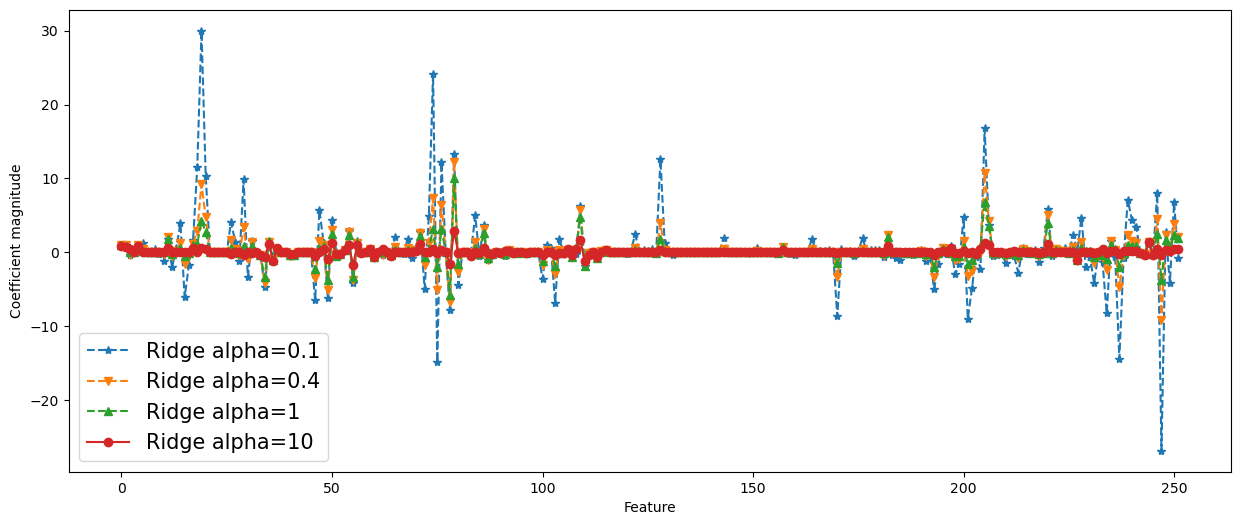

In [66]:
fig = plt.figure(figsize=(15, 6))

plt.plot(ridge1.coef_.T, '--*', label="Ridge alpha=0.1")
plt.plot(ridge4.coef_.T, '--v', label="Ridge alpha=0.4")
plt.plot(ridge_default.coef_.T, '--^', label="Ridge alpha=1")
plt.plot(ridge10.coef_.T, '-o', label="Ridge alpha=10")
#plt.plot(ridge001.coef_.T, '--*', label="Ridge alpha=0.001")
#plt.plot(lr.coef_.T, 'v', label="LinearRegression")
#plt.xticks(range(boston.data.shape[1]), boston.feature_names, rotation=90)
#plt.hlines(0,0, boston.data.shape[1])
#plt.ylim(-20, 20)
plt.xlabel("Feature")
plt.ylabel("Coefficient magnitude")
plt.legend()

print("Weight of the top predictor = %f" %np.amax(np.abs(ridge4.coef_.T)))
print("Top Predictor is Column %s" %np.abs(np.argmax(ridge4.coef_.T)))

(-1.0, 252.0)

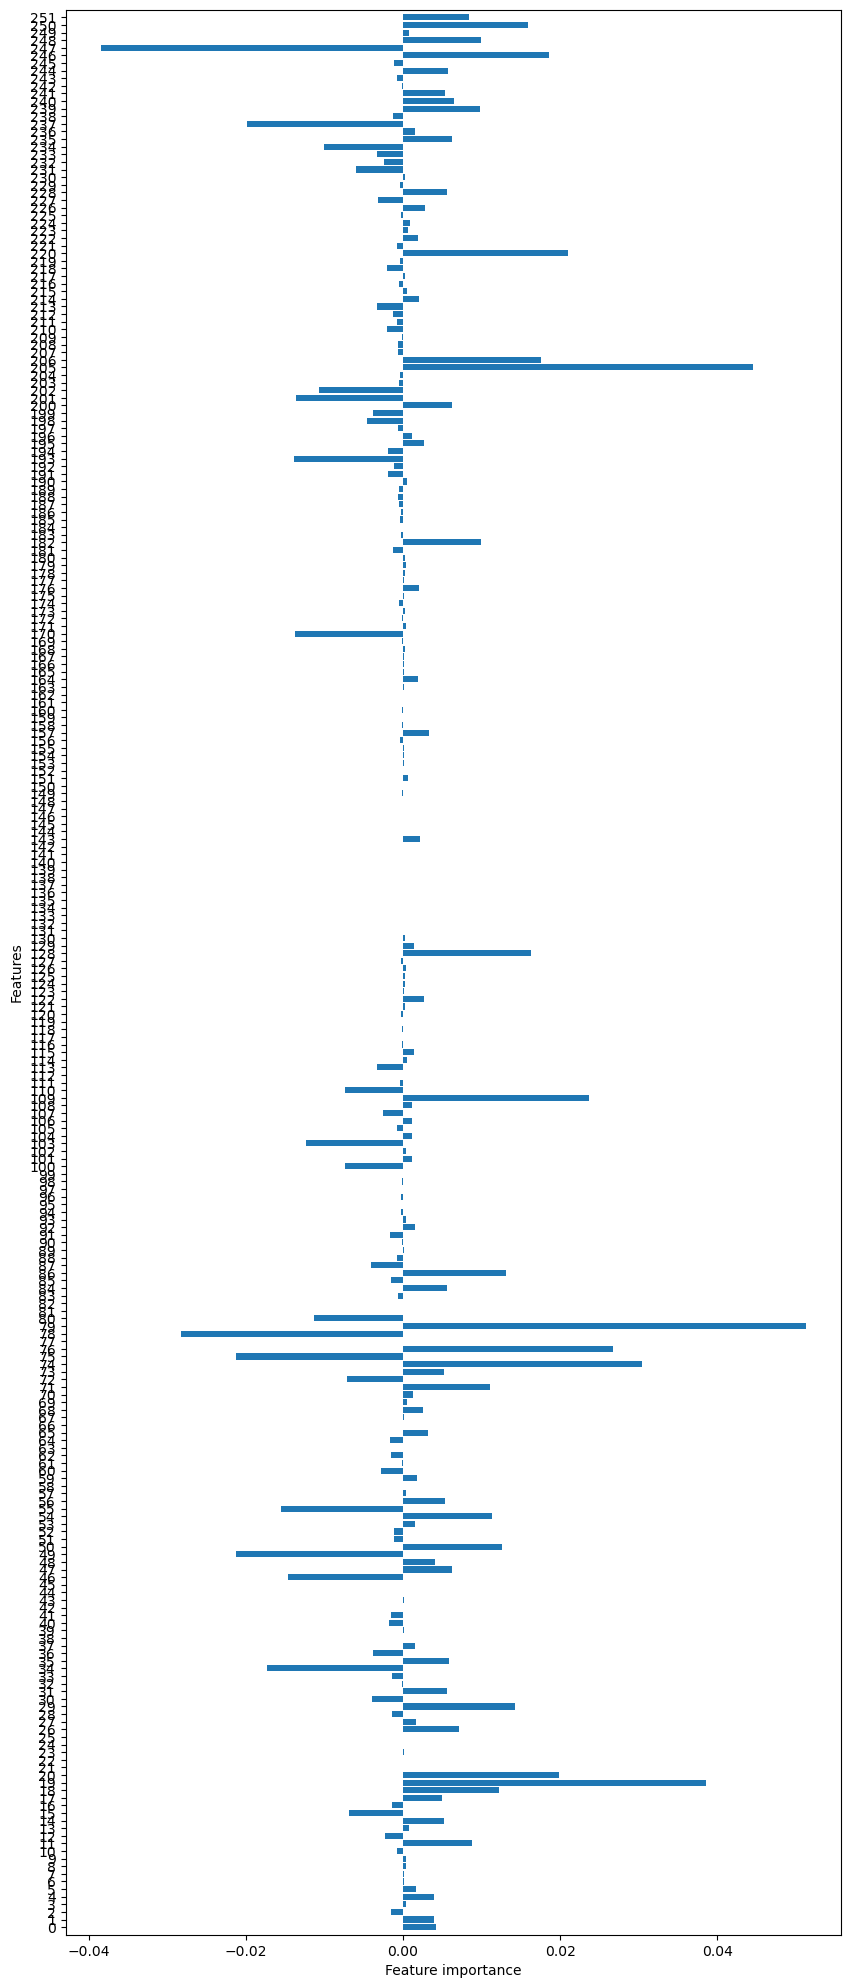

In [67]:
weights_normalized = ridge4.coef_.T/np.sum(np.abs(ridge4.coef_.T))


import numpy as np

fig = plt.figure(figsize=(10, 25))
n_features=252
plt.barh(range(n_features), weights_normalized, align='center')
plt.yticks(np.arange(n_features))
plt.xlabel("Feature importance")
plt.ylabel("Features")
plt.ylim(-1,n_features)

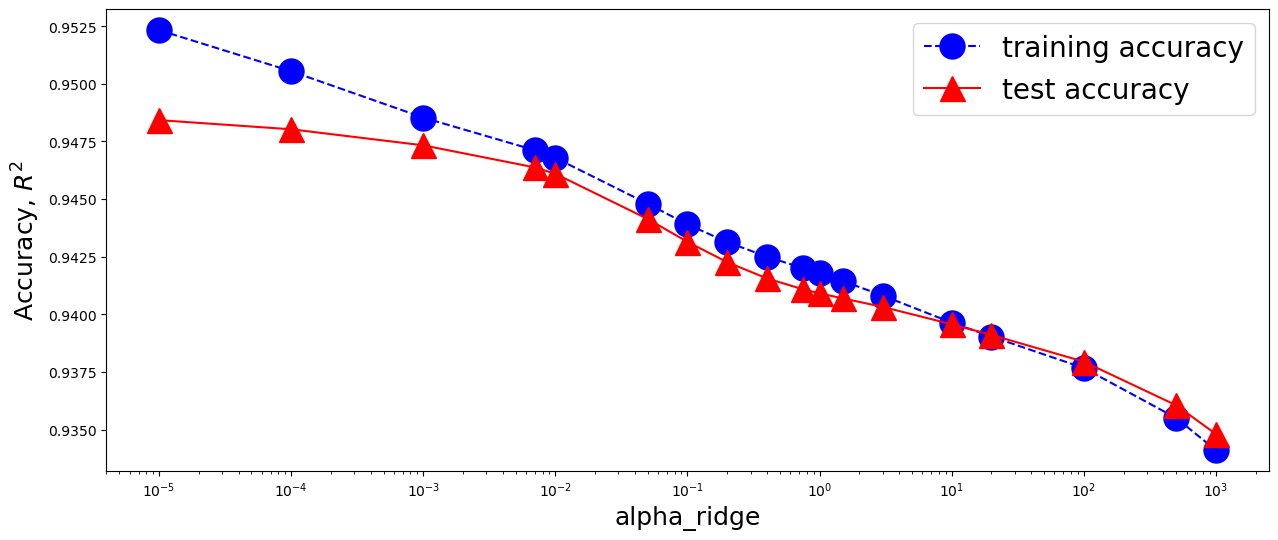

In [68]:
training_accuracy = []
test_accuracy = []
alpha_ridge = [1e-5, 1e-4, 1e-3, 7e-3, 1e-2, 5e-2, 0.1, 0.2,0.4, 0.75, 1, 1.5, 3, 10, 20, 100, 500,1000]

for alpha_run in alpha_ridge:
    ridge = Ridge(alpha=alpha_run).fit(X_train, y_train)
    training_accuracy.append(ridge.score(X_train, y_train))
    test_accuracy.append(ridge.score(X_test, y_test))


fig = plt.figure(figsize=(15, 6))

import pylab as plot
plt.xscale('log')
params = {'legend.fontsize': 20, 'legend.handlelength': 2}
plot.rcParams.update(params)
plt.plot(alpha_ridge, training_accuracy, label="training accuracy", color='blue', marker='o', linestyle='dashed', markersize=18)
plt.plot(alpha_ridge, test_accuracy, label="test accuracy",color='red', marker='^', linestyle='-', markersize=18)
plt.ylabel("Accuracy, $R^2$", fontsize=18)
plt.xlabel("alpha_ridge",fontsize=18)
plt.legend()
pass

In [69]:
No_Trials=20 # Number of Trials

#X, y = mglearn.datasets.load_extended_boston()

all_training = pd.DataFrame()
all_test = pd.DataFrame()


for seedN in range(1,No_Trials,1):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=seedN)
    training_accuracy = []
    test_accuracy = []
    alpha_parameter = [1e-5, 1e-4, 1e-3, 7e-3, 1e-2, 5e-2, 0.1, 0.2,0.4, 0.75, 1, 1.5, 3, 10, 20, 100, 500, 1000,10000, 100000] #Tuning Parameters

    for alpha_run in alpha_parameter:
        reg = Ridge(alpha=alpha_run) # Define here wether Lasso or Ridge
        reg.fit(X_train, y_train) #build the model
        training_accuracy.append(reg.score(X_train, y_train)) # record training set accuracy
        test_accuracy.append(reg.score(X_test, y_test)) # record generalization accuracy
    all_training[seedN]=training_accuracy
    all_test[seedN] = test_accuracy

Best Accuracy = 0.946134
With lpha given by 0.000100


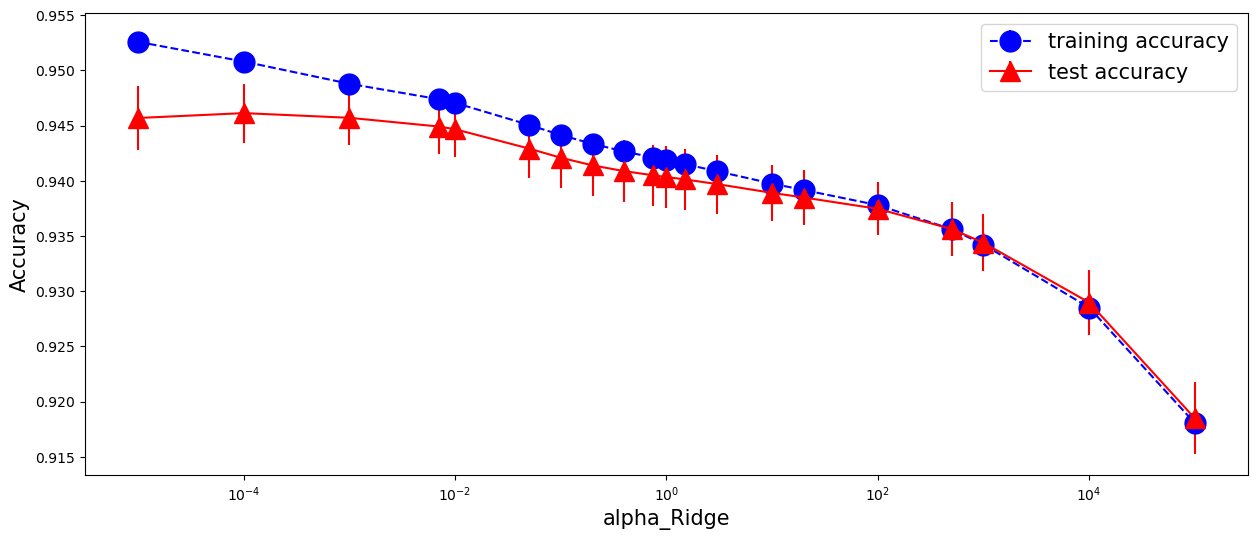

In [70]:
fig = plt.figure(figsize=(15, 6))
import pylab as plot
plt.xscale('log')
#plt.yscale('log')
params = {'legend.fontsize': 15, 'legend.handlelength': 2}
plot.rcParams.update(params)

plt.errorbar(alpha_parameter, all_training.mean(axis=1),
             yerr=all_training.std(axis=1), label="training accuracy", color='blue', marker='o', linestyle='dashed', markersize=15)
plt.errorbar(alpha_parameter, all_test.mean(axis=1),
             yerr=all_test.std(axis=1), label="test accuracy", color='red', marker='^', linestyle='-', markersize=15)
plt.ylabel("Accuracy", fontsize=15)
plt.xlabel("alpha_Ridge",fontsize=15)
plt.legend()

print("Best Accuracy = %f" %np.max(all_test.mean(axis=1)))
print("With \alpha given by %f" %alpha_parameter[np.argmax(all_test.mean(axis=1))])

#### Lasso Regression (L1 Regularization)

In [71]:
from sklearn.linear_model import Lasso
lasso_default = Lasso().fit(X_train, y_train)
print("training set score: %f" % lasso_default.score(X_train, y_train))
print("test set score: %f" % lasso_default.score(X_test, y_test))
print("number of features used: %d" % np.sum(lasso_default.coef_ != 0))

training set score: 0.922292
test set score: 0.917166
number of features used: 22


In [72]:
#We must increase "max_iter" if not the model would warn us to increase it

lasso2 = Lasso(alpha=5, max_iter=10000).fit(X_train, y_train)
print("training set score: %f" % lasso2.score(X_train, y_train))
print("test set score: %f" % lasso2.score(X_test, y_test))
print("number of features used: %d" % np.sum(lasso2.coef_ != 0))

training set score: 0.908027
test set score: 0.902943
number of features used: 17


In [73]:
lasso007 = Lasso(alpha=0.007, max_iter=10000).fit(X_train, y_train)
print("training set score: %f" % lasso007.score(X_train, y_train))
print("test set score: %f" % lasso007.score(X_test, y_test))
print("number of features used: %d" % np.sum(lasso007.coef_ != 0))

training set score: 0.939550
test set score: 0.933721
number of features used: 60


In [74]:
lasso01 = Lasso(alpha=0.01, max_iter=10000).fit(X_train, y_train)
print("training set score: %f" % lasso01.score(X_train, y_train))
print("test set score: %f" % lasso01.score(X_test, y_test))
print("number of features used: %d" % np.sum(lasso01.coef_ != 0))

training set score: 0.938719
test set score: 0.933265
number of features used: 56


In [75]:
lasso001 = Lasso(alpha=0.001, max_iter=100000).fit(X_train, y_train)
print("training set score: %f" % lasso001.score(X_train, y_train))
print("test set score: %f" % lasso001.score(X_test, y_test))
print("number of features used: %d" % np.sum(lasso001.coef_ != 0))

training set score: 0.942839
test set score: 0.934725
number of features used: 78


In [76]:
lasso00001 = Lasso(alpha=0.0001, max_iter=100000).fit(X_train, y_train)
print("training set score: %f" % lasso00001.score(X_train, y_train))
print("test set score: %f" % lasso00001.score(X_test, y_test))
print("number of features used: %d" % np.sum(lasso00001.coef_ != 0))

training set score: 0.948277
test set score: 0.940596
number of features used: 110


Weight of the top predictor = 2.355995
Top Predictor is Column 79
number of features used: 60


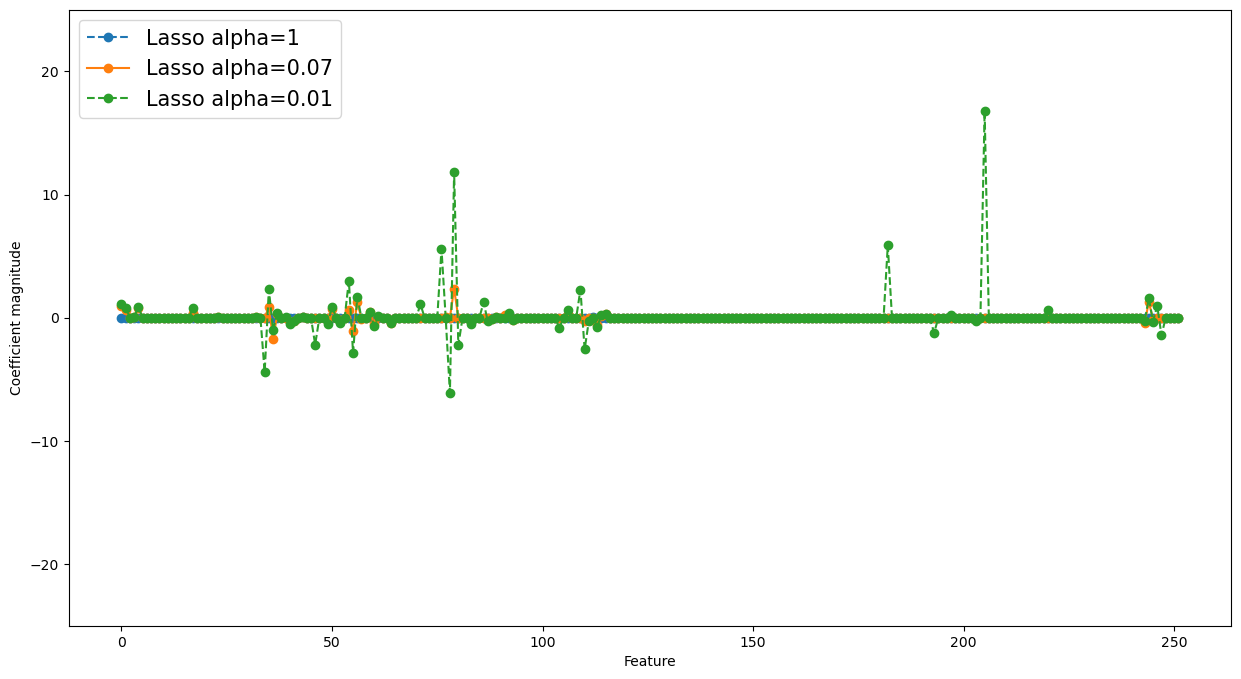

In [77]:
fig = plt.figure(figsize=(15, 8))

plt.plot(lasso_default.coef_, 'o--', label="Lasso alpha=1")
plt.plot(lasso007.coef_, 'o-', label="Lasso alpha=0.07")
plt.plot(lasso001.coef_, 'o--', label="Lasso alpha=0.01")
#plt.plot(ridge1.coef_, 'o-', label="Ridge alpha=0.1")
plt.ylim(-25, 25)

#plt.ylim(-20, 20)
plt.xlabel("Feature")
plt.ylabel("Coefficient magnitude")
plt.legend()


print("Weight of the top predictor = %f" %np.abs(np.amax(lasso007.coef_.T)))
print("Top Predictor is Column %s" %np.abs(np.argmax(lasso007.coef_.T)))
#print("Top Predictor = %s" %boston.feature_names[np.argmax(  )
print("number of features used: %d" % np.sum(lasso007.coef_ != 0))

(-1.0, 252.0)

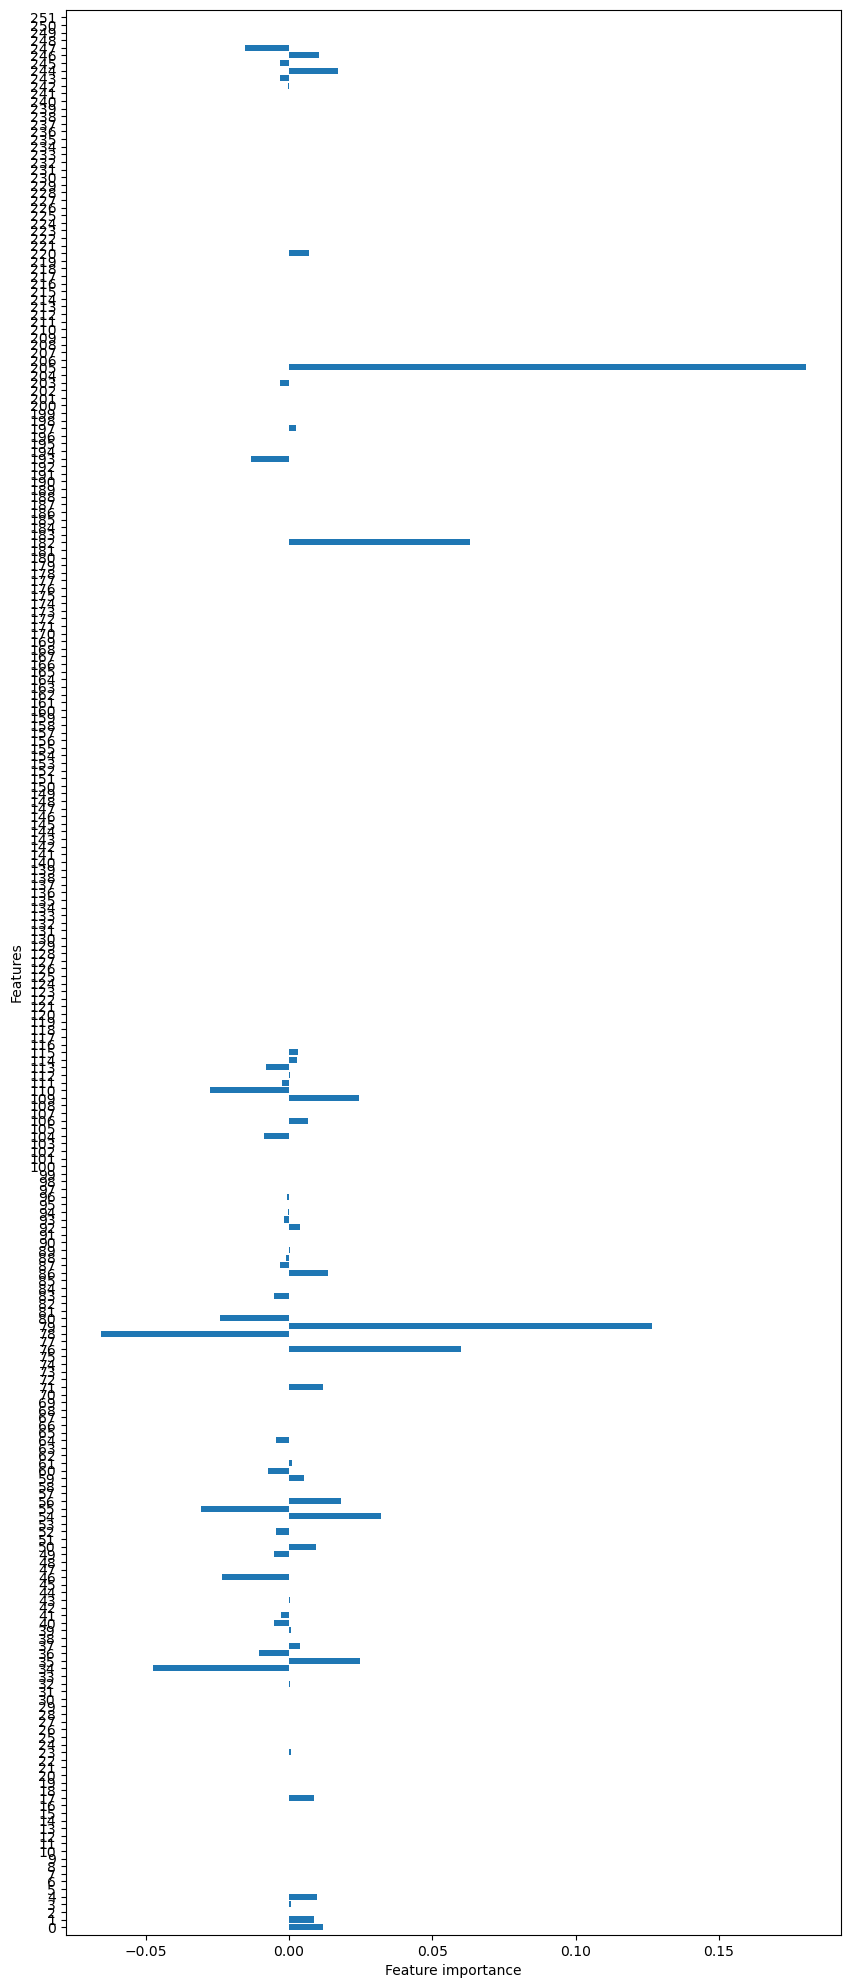

In [79]:
weights_normalized= lasso001.coef_.T/np.sum(np.abs(lasso001.coef_.T))

import numpy as np

fig = plt.figure(figsize=(10, 25))
n_features=252
plt.barh(range(n_features), weights_normalized, align='center')
plt.yticks(np.arange(n_features))
plt.xlabel("Feature importance")
plt.ylabel("Features")
plt.ylim(-1,n_features)

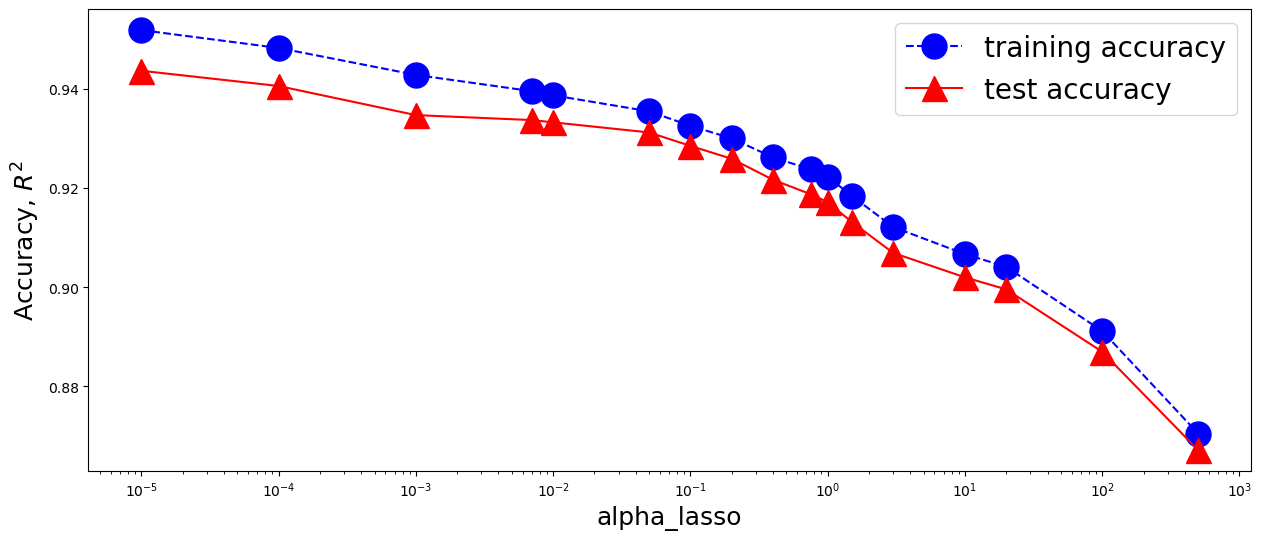

In [80]:
training_accuracy = []
test_accuracy = []
alpha_lasso = [1e-5, 1e-4, 1e-3, 7e-3, 1e-2, 5e-2, 0.1, 0.2,0.4, 0.75, 1, 1.5, 3, 10, 20, 100, 500]

for alpha_run in alpha_lasso:
    lasso = Lasso(alpha=alpha_run,max_iter=100000).fit(X_train, y_train)
    training_accuracy.append(lasso.score(X_train, y_train))
    test_accuracy.append(lasso.score(X_test, y_test))
    #print("alpha_run: %f" % alpha_run)
    #print("training set score: %f" % ridge.score(X_train, y_train))
    #print("test set score: %f\n" % ridge.score(X_test, y_test))

fig = plt.figure(figsize=(15, 6))

import pylab as plot
plt.xscale('log')
params = {'legend.fontsize': 20, 'legend.handlelength': 2}
plot.rcParams.update(params)
plt.plot(alpha_lasso, training_accuracy, label="training accuracy", color='blue', marker='o', linestyle='dashed', markersize=18)
plt.plot(alpha_lasso, test_accuracy, label="test accuracy",color='red', marker='^', linestyle='-', markersize=18)
plt.ylabel("Accuracy, $R^2$", fontsize=18)
plt.xlabel("alpha_lasso",fontsize=18)
plt.legend()
pass

In [81]:
No_Trials=10 # Number of Trials

#X, y = mglearn.datasets.load_extended_boston()

all_training = pd.DataFrame()
all_test = pd.DataFrame()


for seedN in range(1,No_Trials,1):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=seedN)
    training_accuracy = []
    test_accuracy = []
    alpha_parameter = [1e-5, 1e-4, 1e-3, 7e-3, 1e-2, 5e-2, 0.1, 0.2,0.4, 0.75, 1, 1.5, 3, 10, 20, 100, 500] #Tuning Parameters

    for alpha_run in alpha_parameter:
        reg = Lasso(alpha=alpha_run, max_iter=100000) # Define here wether Lasso or Ridge
        reg.fit(X_train, y_train) #build the model
        training_accuracy.append(reg.score(X_train, y_train)) # record training set accuracy
        test_accuracy.append(reg.score(X_test, y_test)) # record generalization accuracy
    all_training[seedN]=training_accuracy
    all_test[seedN] = test_accuracy

print("Best Accuracy = %f" %np.max(all_test.mean(axis=1)))
print("With \alpha given by %f" %alpha_parameter[np.argmax(all_test.mean(axis=1))])

Best Accuracy = 0.945593
With lpha given by 0.000010


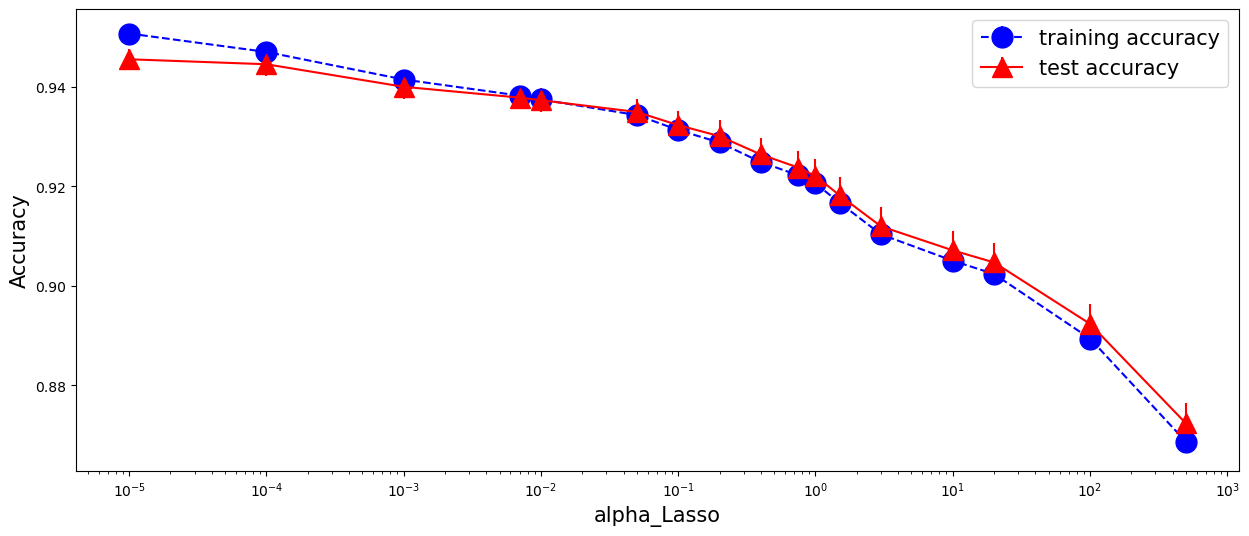

In [82]:
fig = plt.figure(figsize=(15, 6))
import pylab as plot
plt.xscale('log')
#plt.yscale('log')
params = {'legend.fontsize': 15, 'legend.handlelength': 2}
plot.rcParams.update(params)

plt.errorbar(alpha_parameter, all_training.mean(axis=1),
             yerr=all_training.std(axis=1), label="training accuracy", color='blue', marker='o', linestyle='dashed', markersize=15)
plt.errorbar(alpha_parameter, all_test.mean(axis=1),
             yerr=all_test.std(axis=1), label="test accuracy", color='red', marker='^', linestyle='-', markersize=15)
plt.ylabel("Accuracy", fontsize=15)
plt.xlabel("alpha_Lasso",fontsize=15)
plt.legend()